# What I think needs to be refactored

- Each of the code under the for statements in the DistNodeNoParent can be its own function
  - Logic within each of the if statement could also be refactored into separate functions, for example, the logic for getting the distribution for discrete variables can be in a separate function, same for logic for getting distribution for any continuous variables.
  - The fitting function from fitter should be adjusted to avoid the excessive printing. Any way for using tqdm here?

- The for loop within SimNodeNoParent should be a separate function

- The SimulateAvailability Function should only produce an availability matrix, rather than concatenate it to the existing long format dataframe

- Each of the if statements within FitAlternativeRegression should be it's own separate function for fitting logistic regression vs. linear...

- We should write functions that take in a format of regression and produces the needed data. (for all regression equations)

- The for loop that simulates data N times and estimates any models should be written as a helper function.

- Helper function to plot the distribution of causal effects

- Helper function to recompute the regressions after the perturbations of variables.

- All the conditions are also to be written as separate methods.

- We have plenty of parameters that repeat themselves in multiple methods. I think it would be beneficial to create a parameter object that would store all these parameters and allow us to call methods using only one parameter. This will be helpful (in my opinion) while experimenting with different model specifications for example; We would not have to create numerous variables each time for each of the models. Instead, we will create an object (it should be a class in my opinion) from a collection of parameters, then just insert that class in all of our methods for that specific model. The parameters will be attributes of the class.

# Importing packages 

In [1]:
import sys
sys.path.append('../../src/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import copy
from scipy import sparse
import scipy.stats
import random
from fitter import Fitter
import attr
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import defaultdict, OrderedDict
import pylogit as pl
import viz
from array import array

# 0. Deprecated Functions 

In [3]:
# def DistNodeNoParent(data_long,
#                      alt_id_col,
#                      obs_id_col,
#                      alt_spec_dic,
#                      alt_name_dic,
#                      ind_spec,
#                      trip_spec,
#                      var_types,
#                      cont_dists=None):
#     """
#     Function to find the distribution of specific variables
#     from a long format dataset.
    
#     Parameters
#     ----------
#     data_long: Pandas DataFrame
#         Dataset in long format from which variable
#         distribution is to be found.
        
#     alt_id_col: string
#         Name of the column with alternative ids.
        
#     obs_id_col: string
#         Name of the column with observation ids.
        
#     alt_spec_dic: dictionary
#         Dictionary with keys as the ordered number
#         of alternatives, and the value for each key
#         is a list of strings representing the name of
#         variables without parents per alternative.
        
#     alt_name_dic: dictionary
#         Dictionary with keys as the ordered number
#         of alternatives, and the value for each key
#         is a string representing the name of the 
#         alternative.
        
#     ind_spec: list
#         List containing strings of the names of 
#         individual specific variables.
        
#     trip_spec: list
#         List containing string of the names of 
#         trip specific variables.
        
#     var_types: dictionary
#         Dictionary with keys as strings of names of variables
#         from long format dataset, and values for each key are
#         the type of variables (e.g.: 'categorical vs. continuous').
        
#     cont_dists: list
#         List of continuous RVs distribution names from scipy.
        
#     Returns
#     -------
#     a nested dictionary with keys as variable names and values
#     as dictionaries containing both the distribution name and
#     its parameters.
#     """
    
#     params_dict = {}

#     # Code for Individual Specific Variables
#     for ind in ind_spec:
#         # generate array of values for individual specific variable
#         ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])  
#         # Get distribution if variable is categorical
#         var_type = var_types[ind]
#         if var_type in ['categorical', 'numerical']:
#             # If only one category
#             if len(ind_var.unique()) == 1:
#                 params_dict.setdefault(ind,{})['distribution'] = 'constant'
#                 params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
#             # If more than one category
#             else:
#                 params_dict.setdefault(ind,{})['distribution'] = 'categorical'
#                 # Count frequency of values and store it as paramater of distribution
#                 np_array_range = np.arange(ind_var.max()+1)
#                 array_bincount = np.bincount(ind_var)
#                 probs = array_bincount / len(ind_var)
#                 params_dict.setdefault(ind,{})['parameters'] = [np_array_range,
#                                                   probs]
#         else:
#             # If not categorical but just one unique value
#             if len(ind_var.unique()) == 1:
#                 params_dict.setdefault(ind,{})['distribution'] = 'constant'
#                 params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
#             # If not categorical but not one unique value
#             else:
#                 # Use the Fitter library to fit distributions
#                 # to the data
#                 fitter_object = Fitter(data=ind_var,
#                                        distributions=cont_dists,
#                                        timeout=60)
#                 fitter_object.fit()
#                 # Get the best distribution and store in dictionary
#                 BestDict = fitter_object.get_best()
#                 params_dict.setdefault(ind,{})['distribution'] = list(BestDict.items())[0][0]
#                 params_dict.setdefault(ind,{})['parameters'] = list(BestDict.items())[0][1]

#     # Code for Alternative Specific Variables
#     # Loop around the different available alternatives
#     for alt in data_long[alt_id_col].unique():
#         # Store data for specific alternative (mode)
#         mode_data = data_long.loc[data_long[alt_id_col] == alt]
#         # Loop around the alternative specific variables in the input dictionary
#         for var in alt_spec_dic[alt]:
#             # If data is to be taken as empirical values
#             if var_types[var] == 'empirical':
#                 # If only one value
#                 if len(mode_data[var].unique()) == 1:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
#                 else:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'empirical'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = np.array(mode_data[var])
#             # If data is categorical
#             elif var_types[var] == 'categorical':
#                 # If only one category
#                 if len(mode_data[var].unique()) == 1:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
#                 else:
#                     # If more than one category, compute the frequency of values
#                     # and store as parameters
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'categorical'
#                     np_array_range = np.arange(mode_data[var].max()+1)
#                     array_bincount = np.bincount(mode_data[var])
#                     probs = array_bincount / len(mode_data[var])
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = [np_array_range,
#                                                                             probs]
#             else:
#                 # If data is not categorical but has one unique value
#                 if len(mode_data[var].unique()) == 1:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
#                 # If data is not categorical but has more than one unique value
#                 else:
#                     # Use the Fitter library to fit distributions
#                     # to the data
#                     fitter_object = Fitter(data=mode_data[var],
#                                            distributions=cont_dists,
#                                            timeout=60)
#                     fitter_object.fit()
#                     # Get the best distribution and store in dictionary
#                     BestDict = fitter_object.get_best()
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = list(BestDict.items())[0][0]
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = list(BestDict.items())[0][1]

#     # Trip Specific Variable (maybe combine with individual specific variables)
#     # Loop around trip (observation) specific variables
#     for var in trip_spec:
#         # generate array of values for trip specific variable
#         trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
#         # If data is to be taken as empirical values
#         if var_types[var] == 'empirical':
#             # If data has one unique value
#             if trip_var.unique() == 1:
#                 params_dict.setdefault(var, {})['distribution'] = 'constant'
#                 params_dict.setdefault(var, {})['parameters'] = np.array(trip_var.unique())
#             # If data has more than one unique value
#             else:
#                 params_dict.setdefault(var, {})['distribution'] = 'empirical'
#                 params_dict.setdefault(var, {})['parameters'] = np.array(trip_var)
#         # Get distribution if variable is categorical
#         elif var_types[var] == 'categorical':
#             # If only one category
#             if len(trip_var.unique()) == 1:
#                 params_dict.setdefault(var, {})['distribution'] = 'constant'
#                 params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
#             # If more than one category
#             else:
#                 params_dict.setdefault(var, {})['distribution'] = 'categorical'
#                 # Count frequency of values and store it as paramater of distribution
#                 np_array_range = np.arange(trip_var.max()+1)
#                 array_bincount = np.bincount(trip_var)
#                 probs = array_bincount / len(trip_var)
#                 params_dict.setdefault(var, {})['parameters'] = [np_array_range,
#                                                   probs]
#         else:
#             # If not categorical but just one unique value
#             if len(trip_var.unique()) == 1:
#                 params_dict.setdefault(var, {})['distribution'] = 'constant'
#                 params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
#             # If not categorical but just one unique value
#             else:
#                 # Use the Fitter library to fit distributions
#                 # to the data
#                 fitter_object = Fitter(data=trip_var,
#                                        distributions=cont_dists,
#                                        timeout=60)
#                 fitter_object.fit()
#                 # Get the best distribution and store in dictionary
#                 BestDict = fitter_object.get_best()
#                 params_dict.setdefault(var, {})['distribution'] = list(BestDict.items())[0][0]
#                 params_dict.setdefault(var, {})['parameters'] = list(BestDict.items())[0][1]

#     return params_dict


# def SimNodeNoParent(params_dict, size=1000):
#     """
#     Funtion to simulate data of size N based on specified
#     distribution/parameters found by the fitter package.
    
#     Paremeters
#     ----------
#     dist_params: dictionary
#         The variable distribution dictionary resulting from
#         `FindLongDataDist`.
        
#     size: int
#         Size of the desired simulated dataset, default value
#         is 1000 observations.
    
#     Returns
#     -------
#     DataFrame object with simulated data based on specified distributions
#     """
#     # Create Empty DataFrame with keys from params_dict
#     Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
#     Sim_Df = Sim_Df.fillna(0)
    
#     # Loop around each of the variables in params_dict
#     # and simulate data for them
#     for column in list(params_dict.keys()):
#         # Simulate data for categorical variables
#         if params_dict[column]['distribution'] == 'categorical':
#             value = params_dict[column]['parameters'][0]
#             freq = params_dict[column]['parameters'][1]
#             data_sim = np.random.choice(a=value,
#                                         p=freq,
#                                         size=size)
#             Sim_Df[column] = data_sim
        
#         # Simulate variables for data with a single unique value
#         elif params_dict[column]['distribution'] == 'constant':
#             data_sim = params_dict[column]['parameters']
#             Sim_Df[column] = data_sim
        
#         # Simulate data using values from array, sampling
#         # with replacement
#         elif params_dict[column]['distribution'] == 'empirical':
#             data_sim = np.random.choice(params_dict[column]['paramaters'], size=size)
#             Sim_Df[column] = data_sim
        
#         # Simulate data for continuous variables
#         else:
#             # Get scipy distribution from its
#             # name in the params dictionary
#             dist = getattr(scipy.stats,
#                            params_dict[column]['distribution'])
#             data_sim = dist.rvs(*params_dict[column]['parameters'],
#                                 size=size)
#             Sim_Df[column] = data_sim
        
#     return Sim_Df

# def SimulateAvailability(data_long, sim_data, obs_id_col, alt_name_dict):
#     """
#     Function to simulate alternative availability based on a long format
#     dataset and join the availability data to the simulated dataset
#     resulting from SimDf.
    
#     Parameters
#     ----------
#     data_long: Pandas DataFrame
#         Long format dataframe used for simulating
#         alternative availability.
    
#     sim_data: Pandas DataFrame
#         Wide format dataframe resulting from SimDf
    
#     obs_id_col: string
#         Name of the column in data_long with 
#         observation ids.
    
#     alt_name_dic: dictionary
#         Dictionary with keys as the ordered number
#         of alternatives, and the value for each key
#         is a string representing the name of the 
#         alternative.
        
#     Returns
#     -------
#     Wide format Pandas DataFrame with additional availability
#     columns for each of the alternatives.
    
#     """
    
#     # Create empty Series to hold number of available alternatives
#     series = pd.Series([])
    
#     # Loop around each observation to record the
#     # available number of alternatives for each observation
#     for i, obs in zip(np.arange(len(data_long[obs_id_col].unique())), data_long[obs_id_col].unique()):
#         series[i] = data_long[data_long[obs_id_col] == obs].shape[0]

#     # Simulate number of available alternatives for
#     # each observation in sim_data
#     av_size = sim_data.shape[0]
#     alts_sim = np.random.choice(a=np.arange(series.max()+1),
#                                 p=np.bincount(series)/len(series),
#                                 size=av_size)

#     # Simulate the availability matrix based on number 
#     # of available alternatives
#     N = len(alt_name_dict)
#     av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]
    
#     # Shuffle the available alternatives for each observation
#     # because av_sim will always start with 1s
#     for x in av_sim:
#         np.random.shuffle(x)

#     # Shuffle the availability across different observations
#     np.random.shuffle(av_sim)
    
#     # Create columns for the availability matrix
#     AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]
    
#     # Create alternative availability matrix with AV_columns
#     AV_Df = pd.DataFrame(av_sim, columns=AV_columns)
    
#     # Create an random choice column based on available
#     # alternatives for each observation - This column will
#     # be needed when converting to long data
#     fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_Df)]
#     fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])
    
#     # Concatenate the simulated data with availability data and fake choice data
#     # and return Sim_DF_AV
#     Sim_DF_AV = pd.concat([sim_data, AV_Df, fake_choice_df], axis=1, sort=False)
#     return Sim_DF_AV

# 1. Define functions to be used in notebook

In [228]:
## Functions to replace code within
## DistNodeNoParent
## Function for checking length
def is_unique(var_values):
    """
    Checks whether a variable has one unique value.
    """
    return len(var_values.unique()) == 1

def is_empirical(var_type):
    """
    Checks whether the variable type for the
    variable of interest is to be taken
    as a constant value or as numerical values.
    """
    return var_type in ['constant','numerical']

def is_empirical(var_type):
    """
    Checks whether the variable type for the
    variable of interest is to be taken
    as a constant value or as numerical values.
    """
    return var_type == 'empirical'

## Function for checking if variable is categorical
def is_categorical(var_type):
    """Checks whether the variable type for the
    variable of interest is categorical.
    """
    return var_type == 'categorical'

def get_alt_specific_variable_name(var_name, alt_name):
    return var_name + '_' + alt_name

def get_constant_dist(var, var_val, alt_name=None):
    """
    Retrives the constant 'distribution' of a 
    constant variable.
    """
    constant_dict = defaultdict(dict)
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None else get_alt_specific_variable_name(var, alt_name)
    constant_dict[var_name]['distribution'] = 'constant'
    constant_dict[var_name]['parameters'] = var_val.unique()
    return constant_dict

def get_empirical_dist(var, var_val, alt_name=None):
    """
    Retrives the empirical values of the alternative
    specific variable of interest as its distribution.
    """
    empir_dict = defaultdict(dict)
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None else get_alt_specific_variable_name(var, alt_name)
    empir_dict[var_name]['distribution'] = 'empirical'
    empir_dict[var_name]['parameters'] = np.array(var_val)
    return empir_dict

def get_categorical_dist(var, var_val, alt_name=None):
    """
    Retrives the unique values and the proportions
    of observed values for a categorical alternative
    specific variables.
    """
    categ_dict = defaultdict(dict)
    # If more than one category, compute the frequency of values
    # and store as parameters
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None else get_alt_specific_variable_name(var, alt_name)
    categ_dict[var_name]['distribution'] = 'categorical'
    np_array_range = np.arange(var_val.max()+1) #var_val = alt_data[alt_var]
    array_bincount = np.bincount(var_val)
    probs = array_bincount / len(var_val)
    categ_dict[var_name]['parameters'] = [np_array_range,
                                          probs]
    return categ_dict

def get_continuous_dist(var, var_val, alt_name=None, cont_dists): #alt_name_dic[alt]
    """
    Retrives the distribution of continuous alternative
    specific variables using the Fitter package.
    """
    cont_dict = defaultdict(dict)
    # Use the Fitter library to fit distributions
    # to the data
    fitter_object = Fitter(data=var_val,
                           distributions=cont_dists,
                           timeout=60,
                           verbose=False)
    fitter_object.fit()
    # Get the best distribution and store in dictionary
    BestDict = fitter_object.get_best()
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None else get_alt_specific_variable_name(var, alt_name)
    cont_dict[var_name]['distribution'] =\
        list(BestDict.items())[0][0]
    cont_dict[var_name]['parameters'] =\
        list(BestDict.items())[0][1]
    return cont_dict

def get_distribution_dicts(var, var_type, var_val, alt_name=None, cont_dists):
    # If data is categorical
    if is_empirical(var_type):
        # If only one category
        if is_unique(var_val):
            # Add name of alternative to variable
            # and store distriburion & parameters
            dist_dic = get_constant_dist(var, var_val, alt_name)
        else:
            dist_dic = get_empirical_dist(var, var_val, alt_name)
    elif is_categorical(var_type):
        if is_unique(var_val):
            dist_dic = get_constant_dist(var, var_val, alt_name)
        else:
            dist_dic = get_categorical_dist(var, var_val, alt_name)
    else:
        # If data is not categorical but has one unique value
        if is_unique(var_val):
            dist_dic = get_constant_dist(var, var_val, alt_name)
        # If data is not categorical but has more than one unique value
        else:
            dist_dic = get_continuous_dist(var, var_val, alt_name, cont_dists)
    return dist_dic


############################################
############################################
## Functions to replace functionality for
## fitting distributions for variables
## specific variables that have no parents
## in the causal graph.
##############################

def ind_spec_dist(data_long, obs_id_col, ind_spec, var_types, cont_dists):
    """
    Function that retrieves distributions for all individual
    specific variables.
    """
    ind_spec_dict = {}
    for ind_var in ind_spec:
        # generate array of values for individual specific variable
        var_val =\
            (data_long[[obs_id_col, ind_var]]
                .drop_duplicates(obs_id_col, inplace=False)
                .loc[:, ind_var]
                .reset_index(drop=True)
            )  
        # Get distribution of variable
        var_type = var_types[ind_var]
        ind_var_dic =\
            get_distribution_dicts(ind_var,
                                   var_type,
                                   var_val,
                                   cont_dists)
        ind_spec_dict.update(ind_var_dict)
    return ind_spec_dict

def alt_spec_dist(data_long, alt_id_col, alt_spec_dic, var_types, alt_name_dic, cont_dists):
    """
    Function that retrieves distributions for all alternative
    specific variables.
    """
    all_alt_spec_var_dic = defaultdict(dict)
    for alt_id in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        alt_data = data_long.loc[data_long[alt_id_col] == alt_id]
        alt_spec_var_dic = defaultdict(dict)
        # Loop around the alternative specific
        # variables in the input dictionary
        alt_name = alt_name_dic[alt_id]
        for alt_var in alt_spec_dic[alt_id]:
            var_val = alt_data[alt_var]
            var_type = var_types[alt_var]
            alt_spec_var_dist =\
                get_distribution_dicts(alt_var,
                                       var_type,
                                       var_val,
                                       alt_name,
                                       cont_dists)
            alt_spec_var_dic.update(alt_spec_var_dist)
        all_alt_spec_var_dic.update(alt_spec_var_dic)
    return all_alt_spec_var_dic


def trip_spec_dist(data_long, obs_id_col, trip_spec, var_types, cont_dists):
    """
    Function that retrieves distributions for all trip
    specific variables.
    """ 
    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    trip_spec_dict = defaultdict(dict)
    for trip_var in trip_spec:
        # generate array of values for trip specific variable
        var_val =\
            (data_long[[obs_id_col, trip_var]]
                .drop_duplicates(obs_id_col, inplace=False)
                .loc[:, trip_var]
                .reset_index(drop=True)
            )
        var_type = var_types[trip_var]
        # If data is to be taken as empirical values
        trip_spec_var_dist =\
            get_distribution_dicts(trip_var,
                                   var_type,
                                   var_val,
                                   cont_dists)
        trip_spec_dict.update(trip_spec_var_dist)
    return trip_spec_dict


## Define the main function
def get_dist_node_no_parent(data_long,
                            alt_id_col,
                            obs_id_col,
                            alt_spec_dic,
                            alt_name_dic,
                            ind_spec,
                            trip_spec,
                            var_types,
                            cont_dists=None):
    """
    Function to find the distribution of specific variables
    from a long format dataset.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Dataset in long format from which variable
        distribution is to be found.
        
    alt_id_col: string
        Name of the column with alternative ids.
        
    obs_id_col: string
        Name of the column with observation ids.
        
    alt_spec_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a list of strings representing the name of
        variables without parents per alternative.
        
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    ind_spec: list
        List containing strings of the names of 
        individual specific variables.
        
    trip_spec: list
        List containing string of the names of 
        trip specific variables.
        
    var_types: dictionary
        Dictionary with keys as strings of names of variables
        from long format dataset, and values for each key are
        the type of variables (e.g.: 'categorical vs. continuous').
        
    cont_dists: list
        List of continuous RVs distribution names from scipy.
        
    Returns
    -------
    a nested dictionary with keys as variable names and values
    as dictionaries containing both the distribution name and
    its parameters.
    """
    params_dict = {}
    
    # Code for Individual Specific Variables
    ind_spec_dic_params = ind_spec_dist(data_long, obs_id_col, ind_spec, var_types, cont_dists)
    params_dict.update(ind_spec_dic_params)

    # Code for Alternative Specific Variables
    # Loop around the different available alternatives
    alt_spec_dic_params = alt_spec_dist(data_long, alt_id_col, alt_spec_dic, var_types, alt_name_dic, cont_dists) 
    params_dict.update(alt_spec_dic_params)
    
    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    trip_spec_dic_params = trip_spec_dist(data_long, obs_id_col, trip_spec, var_types, cont_dists)
    params_dict.update(trip_spec_dic_params)
    
    return params_dict

In [225]:
## Write functions to replace functionality
## in SimNodeNoParent

def SimCategorical(var_dist_params, size):
    """
    Function to simulate data for
    a categorical/Discrete variable.
    """
    value = var_dist_params[0]
    freq = var_dist_params[1]
    data_sim = np.random.choice(a=value,
                                p=freq,
                                size=size)
    return data_sim

def SimConstant(var_dist_params):
    """
    Function to simulate data for a 
    'constant' variable, in other words,
    a variable that has one empirical value.
    """
    data_sim = var_dist_params
    return data_sim

def SimEmpirical(var_dist_params, size):
    """
    Function to sample with replacement 
    for a variable.
    """
    data_sim = np.random.choice(var_dist_params, size=size)
    return data_sim

def SimContinuous(var_dist, var_dist_params, size):
    """
    Function to simulate data from a continuous
    distribution.
    """
    # Get scipy distribution from its
    # name in the params dictionary
    dist = getattr(scipy.stats,
                   var_dist)
    
    data_sim = dist.rvs(*var_dist_params,
                        size=size)
    return data_sim

def SimNodeNoParent(params_dict, size=1000):
    """
    Funtion to simulate data of size N based on specified
    distribution/parameters found by the fitter package.
    
    Paremeters
    ----------
    dist_params: dictionary
        The variable distribution dictionary resulting from
        `FindLongDataDist`.
        
    size: int
        Size of the desired simulated dataset, default value
        is 1000 observations.
    
    Returns
    -------
    DataFrame object with simulated data based on specified distributions
    """
    # Create Empty DataFrame with keys from params_dict
    Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
    Sim_Df = Sim_Df.fillna(0)

    for column in list(params_dict.keys()):
            # Simulate data for categorical variables
            variable = params_dict[column]
            var_dist = variable['distribution']
            var_dist_params = variable['parameters']
            if isCategorical(var_dist):
                Sim_Df[column] = SimCategorical(var_dist_params, size)

            # Simulate variables for data with a single unique value
            elif isConstant(var_dist):
                Sim_Df[column] = SimConstant(var_dist_params)

            # Simulate data using values from array, sampling
            # with replacement
            elif isEmpirical(var_dist):
                Sim_Df[column] = SimEmpirical(var_dist_params, size)

            # Simulate data for continuous variables
            else:    
                Sim_Df[column] = SimContinuous(var_dist, var_dist_params, size)

    return Sim_Df

In [ ]:
### Functions to replace within SimulateAvailability

# Function to record number of available alternatives
# in each observation
def getNumofAvAlts(data_long, obs_id_col):
    """
    Get the number of available alternatives
    from a long format dataset.
    """
    # Create Empty Series to store num of
    # available alternatives
    series = pd.Series([])
    #Get the unique observations
    observations = data_long[obs_id_col]
    unique_observations = observations.unique()
    index_observations = np.arange(len(unique_observations))
    # loop around unique observations and populate
    # the empty series
    for i, obs in zip(index_observations, unique_observations):
        series[i] = data_long[observations == obs].shape[0]
    return series

# Function to simulate availability matrix
def getAvailabilityMatrix(num_alts, sim_size, alt_name_dict):
    """
    Get the availability matrix based on the number of
    available alternatives, the simulation size,
    and the alternative name dictionary
    """
    # Simulate number of available alternatives for
    # each observation in sim_data
    av_size = sim_size
    alts_sim = np.random.choice(a=np.arange(num_alts.max()+1),
                                p=np.bincount(num_alts)/len(num_alts),
                                size=av_size)

    # simulate the availability matrix based on number 
    # of available alternatives
    N = len(alt_name_dict)
    av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]

    # Shuffle the available alternatives for each observation
    # because av_sim will always start with 1s
    for x in av_sim:
        np.random.shuffle(x)

    # Shuffle the availability across different observations
    np.random.shuffle(av_sim)
    
    # Create columns for the availability matrix
    AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]
    
    # Create alternative availability matrix with AV_columns
    AV_Df = pd.DataFrame(data=av_sim, columns=AV_columns)
    return AV_Df

def SimulateAvailability(data_long, sim_size, obs_id_col, alt_name_dict):
    """
    Function to simulate alternative availability based on a long format
    dataset and join the availability data to the simulated dataset
    resulting from SimDf.
    
    Parameters
    ----------
    data_long: Pandas DataFrame
        Long format dataframe used for simulating
        alternative availability.
    
    sim_size: int
        Size of the simulated dataset
    
    obs_id_col: string
        Name of the column in data_long with 
        observation ids.
    
    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the 
        alternative.
        
    Returns
    -------
    Wide format Pandas DataFrame with additional availability
    columns for each of the alternatives.
    
    """
    # Get an array of the number of available alternatives
    num_alts = getNumofAvAlts(data_long, obs_id_col):
    
    #Create an availability dataframe
    AV_Df = getAvailabilityMatrix(num_alts, sim_size, alt_name_dict)
    
    return AV_Df


# Function to generate fake choice column
# this functionality will be relocated to
# a different function, most likely a function
# that merges availability matrix and simulated
# data or a function that converts to long_data
def createFakeChoiceCol(AV_matrix):
    # Create an random choice column based on available
    # alternatives for each observation - This column will
    # be needed when converting to long data -- this will
    # be moved to a different column
    fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_matrix)]
    fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])
    return fake_choice_df

In [ ]:
def FitAlternativeRegression(regressions, reg_types, data):

def isLinear(variable):
    return variable == 'linear'
def isLogistic(variable):
    return variable == 'logistic'

def fitLinearRegression(data[regressions[reg]]):
    data_x = sm.add_constant(data[regressions[reg][0]])
    data_y = data[regressions[reg][1]]
    model = sm.OLS(data_y, data_x)
    # Fit model
    results = model.fit()
    return results
    # Initiate the regressions results dictionary
    regression_results = {}

def fitBinomialRegression(data[regressions[reg]]):
    # Prepare data and initialize model
    data_x = sm.add_constant(data[regressions[reg][0]])
    data_y = data[regressions[reg][1]]
    model = sm.Logit(data_y, data_x)
    # Fit model
    results = model.fit()
    return results
    
    # Loop around the regressions
    for reg in regressions.keys():
        # If linear regression
        if isLinear(reg_types[reg]):
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = fitLinearRegression(data[regressions[reg]])
        
        # If logistic regression **TODO: Expand on
        # logistic regression
        if isLogistic(reg_types[reg]):
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = fitBinomialRegression(data[regressions[reg]])
    
    #if plotting:
    #    fig = plt.figure(figsize=(12,8))
    #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return regression_results

In [221]:
def FitAlternativeRegression(regressions, reg_types, data):
    
    """
    Function to store regression models based on causal graph
    in a dictionary.
    
    Parameters
    ----------
    regressions: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Values of the dictionary
        are tuples/lists with the first item is a string
        of the name of the independent variable and the
        second item is a string of the name of the 
        dependent variable.
    
    reg_types: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Keys should be similar to the
        keys from the `regressions` dictionary. Values are
        strings representing the type of regressions to be
        ran. **TODO: add more regressions**
        
    Returns
    -------
    Dictionary with keys as the regression name and values
    as regression models stores. Methods from these fitted
    models can be accessed through the values of the dictionary.
    """
    
    # Initiate the regressions results dictionary
    regression_results = {}
    
    # Loop around the regressions
    for reg in regressions.keys():
        # If linear regression
        if reg_types[reg] == 'linear':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.OLS(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
        
        # If logistic regression **TODO: Expand on
        # logistic regression
        if reg_types[reg] == 'logistic':
            # Prepare data and initialize model
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]
            model = sm.Logit(data_y, data_x)

            # Fit model
            results = model.fit()
            
            # Store model
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
    
    #if plotting:
    #    fig = plt.figure(figsize=(12,8))
    #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return regression_results

def PlotParams(sim_par, model, fig_size):
    """
    Function to plot parameters from simulated data.
    
    Parameters
    ----------
    sim_par: Pandas Series or Pandas Column
        Pandas Series or column from DataFrame containing
        coefficients from the estimated models based on
        simulated data.
        
    model: Pylogit model.
        Estimated data generating model to compare 
        estimated parameters based on simulated data
        to.
        
    size: tuple
        Figure size
        
    Returns
    -------
    Seaborn figure of the distribution of estimated parameters
    based on simulated data.
    """
    # Create bins for the histogram
    bins = np.linspace(sim_par.min(), sim_par.max(), 10)
    
    # Initialize the figure size
    plt.figure(figsize=fig_size)
    
    # Plot the distribution
    sns.distplot(sim_par, kde=False, bins=bins, label='Simulated Parameters')
    
    # Add vertical line for the data generating parameter
    plt.axvline(model.coefs[sim_par.name], color='black', ls='--',label='Data Generating Parameter')
    
    # Add a title for the figure
    plt.title(label='Histogram of '+'"'+sim_par.name+'"', fontdict={'fontsize':16})
    
    # Add a y-label
    plt.ylabel('Frequency', rotation=0, labelpad=50)
    
    # Add a legend
    plt.legend()

def FindOutliers(data, threshold=3.5):
    """
    Function to remove outlier data, based on
    the median absolute deviation from the median.
    Note that the function supports asymmetric 
    distributions and is based on code from the
    included reference
    
    Parameters
    ----------
    data: Pandas Series-line
        Series-like containing the simulated
        data in wide format.
        
    threshold: float
        Threshold of the Median Absolute Deviation
        above which data should be removed
        
    Returns
    -------
    Array with True values representing index
    of non-outliers
    
    References
    ----------
    https://eurekastatistics.com/using-the-median-
    absolute-deviation-to-find-outliers/
    
    TODO:
    -----
    We need to discuss whether this approach is 
    appropriate for dropping outlier observations
    """
    
    m = np.median(data)
    abs_dev = np.abs(data - m)
    left_mad = np.median(abs_dev[data <= m])
    right_mad = np.median(abs_dev[data >= m])
    data_mad = left_mad * np.ones(len(data))
    data_mad[data > m] = right_mad
    z_score = abs_dev / data_mad
    z_score[data == m] = 0
    return z_score < threshold

# 2. MNL Model Estimation using Bike Data

## 2.1. Data Ingestion and Exploration

In [77]:
# Create a variable for the path to the long format data for
# the multinomial choice model
PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [78]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [79]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## 2.2. MNL Model Specification 

In [80]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

## 2.3. Model Estimation

In [9]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.22 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Wed, 22 Apr 2020   Pseudo R-squ.:                   0.332
Time:                             17:28:05   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# 3. Framework for Simulation from Causal Graph

## 3.1. Causal Models for each Utility Function 

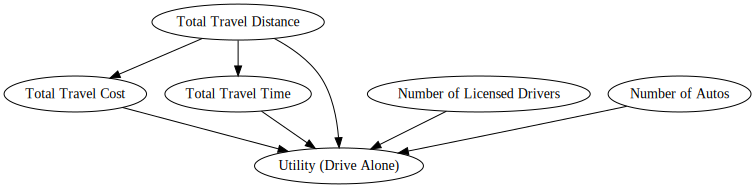

In [81]:
# Define the causal model
V_Drive_Alone = CausalGraphicalModel(nodes=["Total Travel Distance",
                                            "Total Travel Time",
                                            "Total Travel Cost",
                                            "Number of Autos",
                                            "Number of Licensed Drivers",
                                            "Utility (Drive Alone)"],
                                     edges=[("Total Travel Distance","Total Travel Time"),
                                            ("Total Travel Distance","Total Travel Cost"),
                                            ("Total Travel Time", "Utility (Drive Alone)"), 
                                            ("Total Travel Cost", "Utility (Drive Alone)"), 
                                            ("Number of Autos", "Utility (Drive Alone)"),
                                            ("Total Travel Distance", "Utility (Drive Alone)"),
                                            ("Number of Licensed Drivers","Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

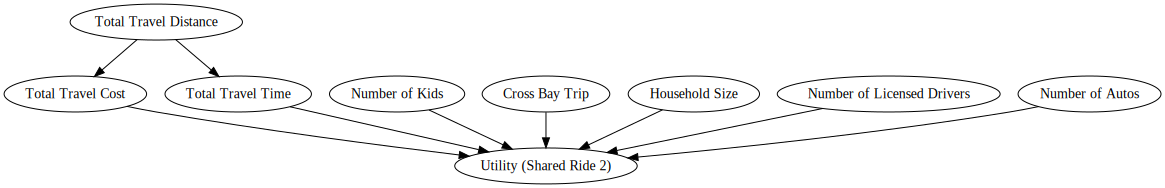

In [82]:
# Define the causal model
V_Shared_2 = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 2)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Time", "Utility (Shared Ride 2)"),
                                         ("Number of Autos", "Utility (Shared Ride 2)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 2)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 2)"),
                                         ("Household Size", "Utility (Shared Ride 2)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                                         ("Number of Kids", "Utility (Shared Ride 2)")
    ]
)

# draw the causal model
V_Shared_2.draw()

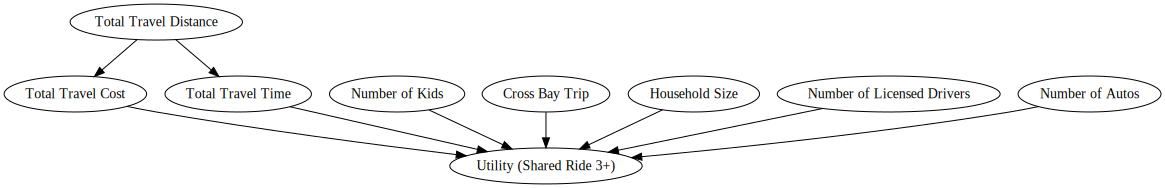

In [83]:
# Define the causal model
V_Shared_3p = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Distance",
                                         "Total Travel Cost",
                                         "Cross Bay Trip",
                                         "Number of Autos",
                                         "Number of Licensed Drivers",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 3+)"],
                                  edges=[("Total Travel Distance","Total Travel Time"),
                                         ("Total Travel Distance","Total Travel Cost"),
                                         ("Total Travel Time", "Utility (Shared Ride 3+)"),
                                         ("Number of Autos", "Utility (Shared Ride 3+)"),
                                         ("Number of Licensed Drivers", "Utility (Shared Ride 3+)"),
                                         ("Total Travel Cost", "Utility (Shared Ride 3+)"),
                                         ("Household Size", "Utility (Shared Ride 3+)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                                         ("Number of Kids", "Utility (Shared Ride 3+)")
    ]
)

# draw the causal model
V_Shared_3p.draw()

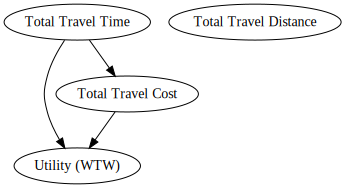

In [84]:
# Define the causal model
V_WTW = CausalGraphicalModel(nodes=["Total Travel Distance",
                                    "Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTW)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (WTW)"),
                                         ("Total Travel Cost", "Utility (WTW)")
    ]
)

# draw the causal model
V_WTW.draw()

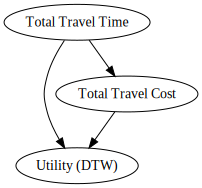

In [85]:
# Define the causal model
V_DTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (DTW)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                    ("Total Travel Time", "Utility (DTW)"),
                                    ("Total Travel Cost", "Utility (DTW)")
    ]
)

# draw the causal model
V_DTW.draw()

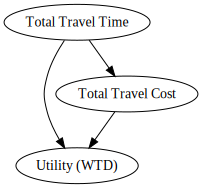

In [86]:
# Define the causal model
V_WTD = CausalGraphicalModel(nodes=["Total Travel Time",
                                    "Total Travel Cost",
                                    "Utility (WTD)"],
                             edges=[("Total Travel Time", "Total Travel Cost"),
                                    ("Total Travel Time", "Utility (WTD)"),
                                    ("Total Travel Cost", "Utility (WTD)")
    ]
)

# draw the causal model
V_WTD.draw()

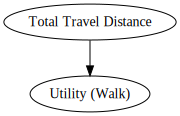

In [87]:
# Define the causal model
V_Walk = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Walk)"],
                              edges=[("Total Travel Distance", "Utility (Walk)")
    ]
)

# draw the causal model
V_Walk.draw()

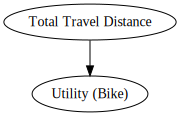

In [88]:
# Define the causal model
V_Bike = CausalGraphicalModel(nodes=["Total Travel Distance",
                                     "Utility (Bike)"],
                              edges=[("Total Travel Distance", "Utility (Bike)")
    ]
)

# draw the causal model
V_Bike.draw()

## 3.2. Distribution of Nodes without parents

### 3.2.1. Set up all needed variables

In [143]:
# Observation id column
observation_id_col = 'observation_id'

# Alternative id column
alternative_id_col = 'mode_id'

# Individual specific variables list
individual_specific_variables = ['household_size','num_kids',
                                'num_cars','num_licensed_drivers']

# Alternative specific variables dictionary
alternative_specific_dict = {1: ['total_travel_distance'],
                             2: ['total_travel_distance'],
                             3: ['total_travel_distance'],
                             4: ['total_travel_time'],
                             5: ['total_travel_time'],
                             6: ['total_travel_time'],
                             7: ['total_travel_distance'],
                             8: ['total_travel_distance']}

# Trip specific variables list
trip_specific_variables = ['cross_bay']

# Alternative name dictionary
alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

# Variable type Dictionary
variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
distributions = ['norm', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

### 3.2.2. Find Distributions of nodes without parents 

In [144]:
bike_data_params = DistNodeNoParent(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec_dic=alternative_specific_dict,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                    cont_dists=distributions)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [145]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'num_kids': {'distribution': 'categorical',
  'parameters': [array([0, 1, 2, 3, 4, 5, 6]),
   array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
          0.00699301, 0.0014985 ])]},
 'num_cars': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
          0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
 'num_licensed_drivers': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
   array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
          4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
 'total_travel_distance_drive_alone': {'distribution': 'beta',
  'par

In [140]:
bike_data_long[bike_data_long.mode_id==1]['total_travel_distance'].mean()

15.579497896950548

In [144]:
# bike_data_params = {'household_size': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6., 7., 8.),
#    (0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
#           0.12012987, 0.02997003, 0.00949051, 0.01123876)]},
#  'num_kids': {'distribution': 'categorical',
#   'parameters': [(0, 1, 2, 3, 4, 5, 6),
#    (0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
#           0.00699301, 0.0014985)]},
#  'num_cars': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6., 7., 8.),
#    (0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
#           0.00674326, 0.0024975 , 0.000999  , 0.000999  )]},
#  'num_licensed_drivers': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6.),
#    (1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
#           4.47052947e-02, 9.24075924e-03, 4.99500500e-04)]},
#  'total_travel_distance_drive_alone': {'distribution': 'halfcauchy',
#   'parameters': (0.39999999242619755, 7.6204182567397165)},
#  'total_travel_distance_shared_2': {'distribution': 'halfcauchy',
#   'parameters': (0.299999998957803, 7.584262028819065)},
#  'total_travel_distance_shared_3p': {'distribution': 'halfcauchy',
#   'parameters': (0.2999999999587918, 7.590903048398837)},
#  'total_travel_time_wtw': {'distribution': 'exponnorm',
#   'parameters': (4.461798763613399, 42.0335875728394, 14.161218106029043)},
#  'total_travel_time_dtw': {'distribution': 'fatiguelife',
#   'parameters': (0.5059992383788099, -10.97225146372076, 88.46124182265194)},
#  'total_travel_time_wtd': {'distribution': 'exponnorm',
#   'parameters': (3.4963501604509, 35.01068856093334, 14.76505046778292)},
#  'total_travel_distance_walk': {'distribution': 'halfcauchy',
#   'parameters': (0.29999999866469995, 6.616044249480995)},
#  'total_travel_distance_bike': {'distribution': 'halfcauchy',
#   'parameters': (0.3599999792235668, 5.810827941041648)},
#  'cross_bay': {'distribution': 'categorical',
#   'parameters': [np.array([0, 1]), np.array([0.94005994, 0.05994006])]}}

## 3.3. Regressions for each causal graph 

### 3.3.1. Drive Alone 

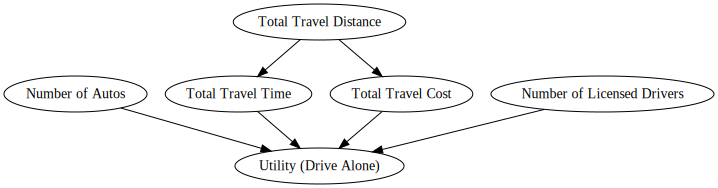

In [20]:
V_Drive_Alone.draw()

In [21]:
Drive_Alone_Df = bike_data_long[bike_data_long['mode_id']==1]
Drive_Alone_Df.reset_index(drop=True,inplace=True)
Drive_Alone_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Drive_Alone_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.2. Shared-2

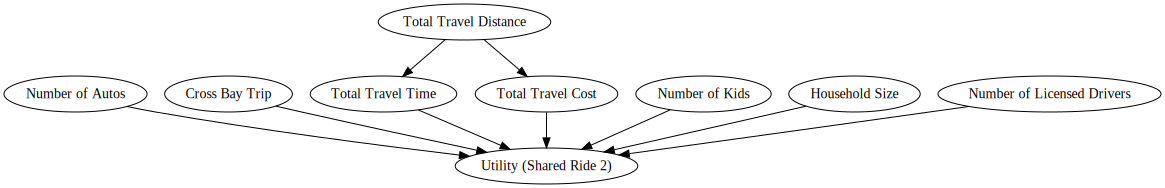

In [22]:
V_Shared_2.draw()

In [23]:
Shared_2_Df = bike_data_long[bike_data_long['mode_id']==2]
Shared_2_Df.reset_index(drop=True,inplace=True)
Shared_2_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_2_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.3. Shared-3+

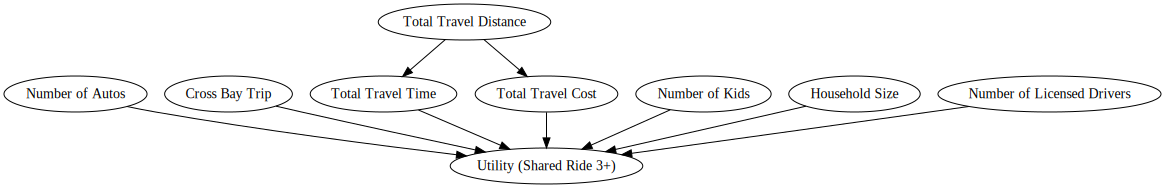

In [24]:
V_Shared_3p.draw()

In [25]:
Shared_3p_Df = bike_data_long[bike_data_long['mode_id']==3]
Shared_3p_Df.reset_index(drop=True,inplace=True)
Shared_3p_Reg = FitAlternativeRegression(regressions={1:('total_travel_distance','total_travel_cost'),
                                                        2:('total_travel_distance','total_travel_time')},
                                           reg_types={1:'linear',2:'linear'},
                                           data = Shared_3p_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.4. Walk-Transit-Walk 

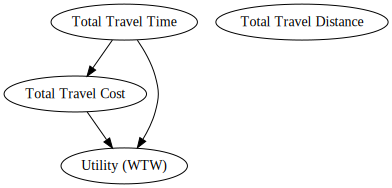

In [26]:
V_WTW.draw()

In [27]:
WTW_Df = bike_data_long[bike_data_long['mode_id']==4]
WTW_Df.reset_index(drop=True,inplace=True)
WTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTW_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.5. Drive-Transit-Walk 

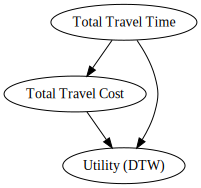

In [28]:
V_DTW.draw()

In [29]:
DTW_Df = bike_data_long[bike_data_long['mode_id']==5]
DTW_Df.reset_index(drop=True,inplace=True)
DTW_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = DTW_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.6. Walk-Transit-Drive 

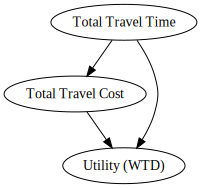

In [30]:
V_WTD.draw()

In [31]:
WTD_Df = bike_data_long[bike_data_long['mode_id']==6]
WTD_Df.reset_index(drop=True,inplace=True)
WTD_Reg = FitAlternativeRegression(regressions={1:('total_travel_time','total_travel_cost')},
                                           reg_types={1:'linear'},
                                           data = WTD_Df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.7. Walk

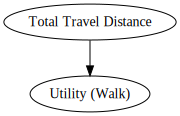

In [32]:
V_Walk.draw()

No regressions needed under the Walk alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

### 3.3.8. Bike

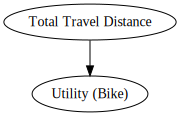

In [33]:
V_Bike.draw()

## 3.4. Simulate Nodes without Parents 

In [36]:
sim_size = 8000
sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)

## 3.5. Simulate data for each causal graph

In [37]:
# Create a copy of the data to avoid any issues
sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

### 3.5.1. Drive Alone 

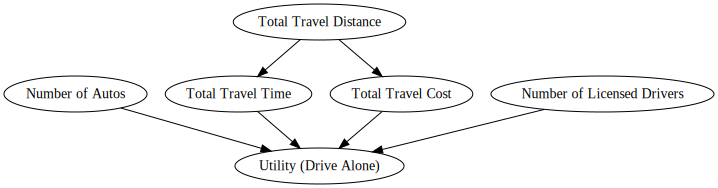

In [38]:
V_Drive_Alone.draw()

In [39]:
sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [40]:
# ## Loading data into StructuralCausalModel
# Drive_Alone_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_drive_alone'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "utility_drive_alone": lambda n_samples: np.zeros(shape=n_samples)
# })

# Drive_Alone_Model.sample(n_samples=4000).head()

### 3.5.2. Shared-2 

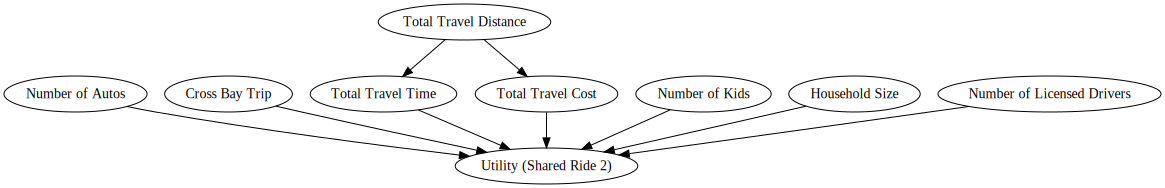

In [41]:
V_Shared_2.draw()

In [42]:
sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [43]:
# ## Loading data into StructuralCausalModel
# Shared_2_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_shared_2'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "household_size": lambda n_samples: bike_data_no_parent['household_size'],
#     "num_kids": lambda n_samples: bike_data_no_parent['num_kids'],
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "cross_bay": lambda n_samples: bike_data_no_parent['cross_bay'],
#     "utility_shared_2": total_travel_cost: lambda n_samples: np.zeros(shape=bike_data_no_parent['total_travel_distance_shared_2'].shape[0])
# })
# Shared_2_Model.sample(n_samples=4000).head()

### 3.5.3. Shared-3+

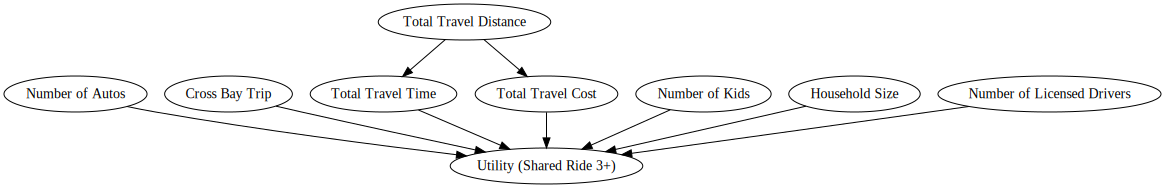

In [44]:
V_Shared_3p.draw()

In [45]:
sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)
sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = sim_size)

In [46]:
# ## Loading data into StructuralCausalModel
# Shared_3p_Model = StructuralCausalModel({
#     "total_travel_distance": lambda   n_samples: bike_data_no_parent['total_travel_distance_shared_3p'],
#     "total_travel_time": lambda total_travel_distance, n_samples: Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + 
#                                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "total_travel_cost": lambda total_travel_distance, n_samples: Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] + 
#                                                                   Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] * 
#                                                                   bike_data_no_parent['total_travel_distance_drive_alone'] + 
#                                                                   np.random.normal(loc=0,
#                                                                                    scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                                    size = n_samples),
#     "household_size": lambda n_samples: bike_data_no_parent['household_size'],
#     "num_kids": lambda n_samples: bike_data_no_parent['num_kids'],
#     "num_licensed_drivers": lambda n_samples: bike_data_no_parent['num_licensed_drivers'],
#     "num_cars": lambda n_samples: bike_data_no_parent['num_cars'],
#     "cross_bay": lambda n_samples: bike_data_no_parent['cross_bay'],
#     "utility_shared_3+": lambda n_samples: np.zeros(shape=n_samples)
# })

### 3.5.4. Walk-Transit-Walk

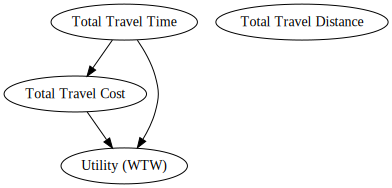

In [47]:
V_WTW.draw()

In [48]:
sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.5. Drive-Transit-Walk

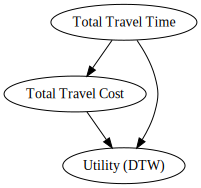

In [49]:
V_DTW.draw()

In [50]:
sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.6. Walk-Transit-Drive

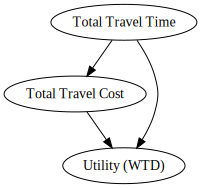

In [51]:
V_WTD.draw()

In [52]:
sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = sim_size)

### 3.5.7. Walk

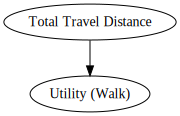

In [53]:
V_Walk.draw()

No need to simulate any other variables since Walk Total Travel Distance was already simulated

### 3.5.8. Bike

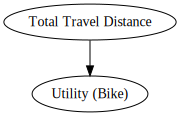

In [54]:
V_Bike.draw()

No need to simulate any other variables since Bike Total Travel Distance was already simulated

## 3.6. Simulate Availability of Alternatives 

In [55]:
# Simulate availability, add fake choice column
# and return final simulated data with availability
# and choices
wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                     sim_data=sim_bike_data_wide,
                                     obs_id_col=observation_id_col,
                                     alt_name_dict=alternative_name_dict)

In [179]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'num_kids': {'distribution': 'categorical',
  'parameters': [array([0, 1, 2, 3, 4, 5, 6]),
   array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
          0.00699301, 0.0014985 ])]},
 'num_cars': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
          0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
 'num_licensed_drivers': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
   array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
          4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
 'total_travel_distance_drive_alone': {'distribution': 'gamma',
  'pa

In [56]:
sim_bike_data_wide.columns

Index(['household_size', 'num_kids', 'num_cars', 'num_licensed_drivers',
       'total_travel_distance_drive_alone', 'total_travel_distance_shared_2',
       'total_travel_distance_shared_3p', 'total_travel_time_wtw',
       'total_travel_time_dtw', 'total_travel_time_wtd',
       'total_travel_distance_walk', 'total_travel_distance_bike', 'cross_bay',
       'total_travel_time_drive_alone', 'total_travel_cost_drive_alone',
       'total_travel_time_shared_2', 'total_travel_cost_shared_2',
       'total_travel_time_shared_3p', 'total_travel_cost_shared_3p',
       'total_travel_cost_wtw', 'total_travel_cost_dtw',
       'total_travel_cost_wtd'],
      dtype='object')

## 3.7. Convert Simulated Data from Wide to Long

In [57]:
ind_variables = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']



# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')]),
                            }


# Dictionary of alternative availability variables
availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "observation_id"
wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                         dtype=int) + 1


# Declare choice column
choice_column = "sim_choice"

In [58]:
# Convert data from wide to long
long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)

In [59]:
# Create a cars per licensed drivers column
long_sim_data["cars_per_licensed_drivers"] = 0
long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                  "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

In [60]:
# Add a variable representing cost divided by distance
long_sim_data["cost_per_distance"] = 0
long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                  "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_cost"] /
                                          long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_distance"])

## 3.8. Simulate Choices 

In [61]:
# Calculate probabilities for each alternative
# based on the estimated model
posterior_probs = mnl_model.predict(long_sim_data)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [62]:
# Simulate choice data
long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)

## 3.9. Estimate Model

In [63]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model_sim.fit_mle(np.zeros(num_vars),
                      method="BFGS")

# Look at the estimation results
mnl_model_sim.get_statsmodels_summary()

Log-likelihood at zero: -15,206.3536
Initial Log-likelihood: -15,206.3536


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.80 seconds.
Final log-likelihood: -5,751.8401


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,981
Method:                                MLE   Df Model:                           19
Date:                     Wed, 22 Apr 2020   Pseudo R-squ.:                   0.622
Time:                             17:35:56   Pseudo R-bar-squ.:               0.620
AIC:                            11,541.680   Log-Likelihood:             -5,751.840
BIC:                            11,674.437   LL-Null:                   -15,206.354
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -0.8745      0.125     -7.009      0.000      -1.119      -0.630
ASC Shared Ride: 3+                                      3.5761      0.199     17.975      0.000       3.186       3.966
ASC Walk-Transit-Walk                                   -0.3658      0.137     -2.664      0.008      -0.635      -0.097
ASC Drive-Transit-Walk                                  -2.5185      0.145    -17.426      0.000      -2.802      -2.235
ASC Walk-Transit-Drive                                  -2.9429      0.154    -19.074      0.000      -3.245      -2.640
ASC Walk                                                 1.7689      0.143     12.393      0.000       1.489       2.049
ASC Bike                                                -0.9221      0.112     -8.202      0.000      -1.142      -0.702
Travel Time, units:min (All Auto Modes)                 -0.0735      0.002    -33.026      0.000      -0.078      -0.069
Travel Time, units:min (All Transit Modes)              -0.0267      0.001    -18.413      0.000      -0.030      -0.024
Travel Cost, units:$ (All Transit Modes)                -0.1161      0.019     -6.158      0.000      -0.153      -0.079
Travel Cost per Distance, units:$/mi (Drive Alone)      -4.7978      0.179    -26.821      0.000      -5.148      -4.447
Travel Cost per Distance, units:$/mi (SharedRide-2)    -19.7831      0.622    -31.788      0.000     -21.003     -18.563
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -89.4322      2.665    -33.559      0.000     -94.655     -84.209
Autos per licensed drivers (All Auto Modes)              1.2484      0.060     20.977      0.000       1.132       1.365
Travel Distance, units:mi (Walk)                        -1.0618      0.037    -28.472      0.000      -1.135      -0.989
Travel Distance, units:mi (Bike)                        -0.2997      0.015    -20.053      0.000      -0.329      -0.270
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.8094      0.166      4.879      0.000       0.484       1.135
Household Size (Shared Ride 2 & 3+)                      0.0794      0.028      2.837      0.005       0.025       0.134
Number of Kids in Household (Shared Ride 2 & 3+)         0.5990      0.034     17.470      0.000       0.532       0.666
========================================================================================================================
"""

# 4. Estimate Causal Effects

## 4.1 Compute Initial Probabilities Using Estimated Model on Simulated Data

In [64]:
initial_probabilities = mnl_model_sim.predict(long_sim_data)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


## 4.2. Independently Generated Variables

### 4.2.1. Disturb X Independently

In [65]:
long_sim_data_naive = copy.deepcopy(long_sim_data)
long_sim_data_naive['total_travel_distance'] = 0.95 * long_sim_data_naive['total_travel_distance']

### 4.2.2. Compute Naive Probabilities Using Disturbed data and Estimated Model on Simulated Data

In [66]:
naive_probabilities = mnl_model_sim.predict(long_sim_data_naive)
long_sim_data_naive['naive_probabilities'] = naive_probabilities

## 4.3. Based on Causal Graph and Estimated Model from Simulated

In [67]:
long_sim_data_causal = copy.deepcopy(long_sim_data)

### 4.3.1. Perturb X and children nodes

In [68]:
long_sim_data_causal['total_travel_distance'] = 0.95 * long_sim_data['total_travel_distance']

### Drive Alone

In [69]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]

6890

In [70]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_time'] = \
                                                  (Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_cost'] = \
                                                 (Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

### Shared-2

In [71]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_time'] = \
                                                  (Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))

long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_cost'] = \
                                                 (Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))

### Shared-3+

In [72]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_time'] = \
                                                  (Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))

long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_cost'] = \
                                                 (Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))

### Walk-Transit-Walk

In [73]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_cost'] = \
                                                 (WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4].shape[0]))

### Drive-Transit-Walk

In [74]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_cost'] = \
                                                 (DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5].shape[0]))

### Walk-Transit-Drive

In [75]:
long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_cost'] = \
                                                 (WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6].shape[0]))

### Walk 

No further change of variables since travel distance directly affects the utility.

### Bike 

No further change of variables since travel distance directly affects the utility.

### 4.3.2. Compute Estimated Probabilities

In [76]:
estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal)
long_sim_data_causal['estimated_probabilities'] = estimated_probabilities

## 4.4. Based on True Causal Graph and Original Estimated Model

In [77]:
true_probabilities = mnl_model.predict(long_sim_data_causal)
long_sim_data_causal['true_probabilities'] = true_probabilities

In [78]:
long_sim_data['initial_probabilities'] = initial_probabilities

## 4.5. Calculate Causal Effects

In [79]:
naive_effect = long_sim_data_naive.loc[long_sim_data_naive['mode_id'].isin([1, 2, 3]),'naive_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
estimated_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'estimated_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
true_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'true_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']

## 4.6. Distribution of Causal Effect by observation

Text(0.5, 1.0, 'True Effect vs. Estimated Effect')

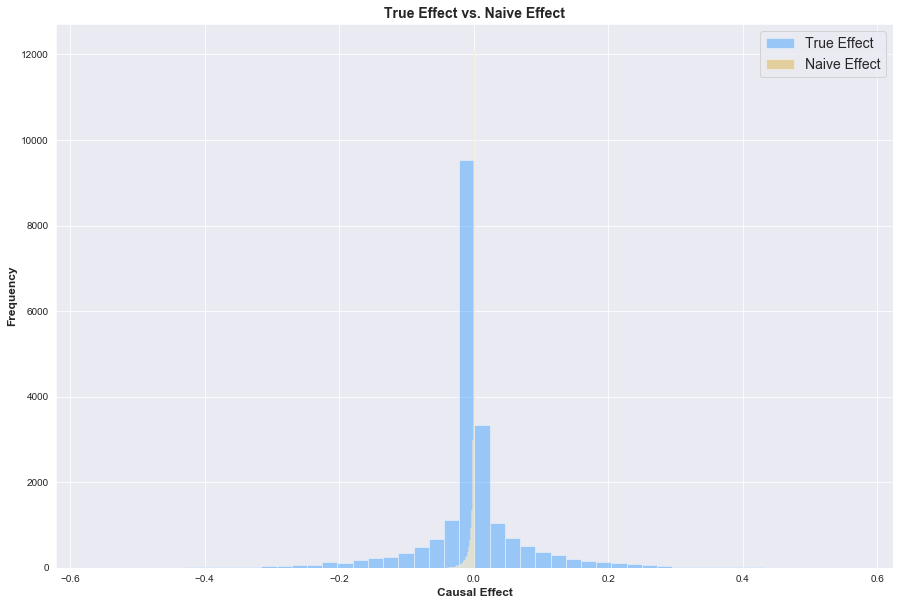

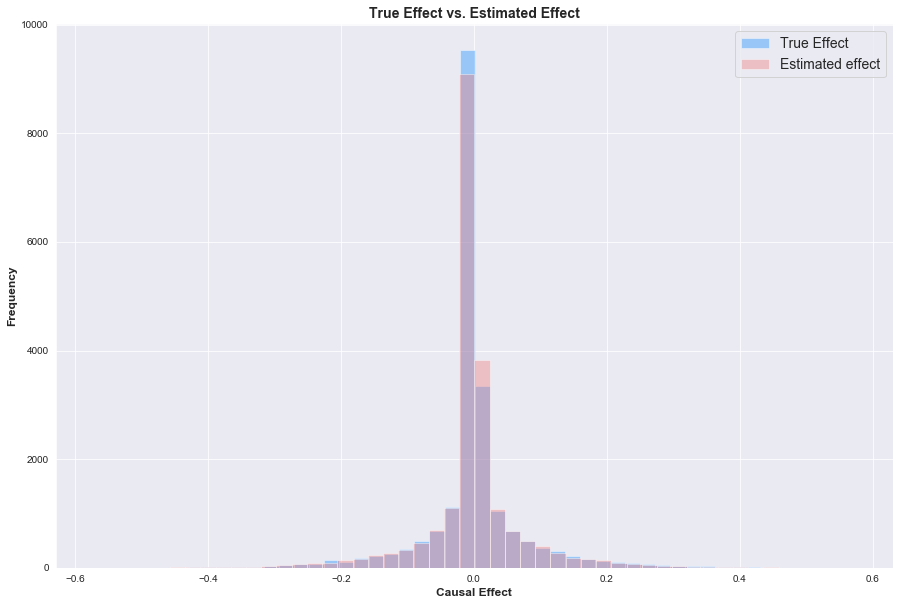

In [80]:
plt.figure(figsize=(15,10))
sns.distplot(true_effect, kde=False, label ='True Effect', color='dodgerblue')
sns.distplot(naive_effect, kde=False, label ='Naive Effect', color='goldenrod')
plt.xlabel('Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})
plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})

plt.figure(figsize=(15,10))
sns.distplot(true_effect, kde=False, label ='True Effect', color='dodgerblue')
sns.distplot(estimated_effect, kde=False, label ='Estimated effect', color='lightcoral')
plt.xlabel('Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})
plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})

# 5. Repeat Simulation N times and compute Average Causal Effects

### 5.1. Run the repeated simulation

In [82]:
simulation_sizes = np.random.randint(low=3000, high=9000, size=400)
sim_number = np.arange(1,401)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}

for sim_size, number in zip(simulation_sizes, sim_number):
    print('Simulation number', number , 'is in progress...')
    print ('Simulation size is', sim_size)
    print('------------------------------------------')
    print('Simulating data...')
    # Simulate data without parents
    sim_bike_data_no_parent = SimNodeNoParent(bike_data_params, size=sim_size)
    
    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    ############ Simulate nodes based on causal graphs ############
    ############ Drive Alone ############
    sim_bike_data_wide['total_travel_time_drive_alone'] = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    sim_bike_data_wide['total_travel_cost_drive_alone'] = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_drive_alone'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    
    # Shared Ride 2
    sim_bike_data_wide['total_travel_time_shared_2'] = Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                               Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    sim_bike_data_wide['total_travel_cost_shared_2'] = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  sim_bike_data_wide['total_travel_distance_shared_2'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size=sim_size)
    ############ Shared Ride 3+ ############
    sim_bike_data_wide['total_travel_time_shared_3p'] = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] +\
                                                   Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] *\
                                                      sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                      np.random.normal(loc=0,
                                                                       scale=Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                       size=sim_size)
    sim_bike_data_wide['total_travel_cost_shared_3p'] = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                      Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                      sim_bike_data_wide['total_travel_distance_shared_3p'] +\
                                                      np.random.normal(loc=0,
                                                                       scale=Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                       size=sim_size)
    ############ Walk-Transit-Walk ############
    sim_bike_data_wide['total_travel_cost_wtw'] = WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale=WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size=sim_size)
    ############ Drive-Transit-Walk ############
    sim_bike_data_wide['total_travel_cost_dtw'] = DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_dtw'] +\
                                                  np.random.normal(loc=0,
                                                                   scale =DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size =sim_size)
    ############ Walk-Transit-Drive ############
    sim_bike_data_wide['total_travel_cost_wtd'] = WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  sim_bike_data_wide['total_travel_time_wtd'] +\
                                                  np.random.normal(loc=0,
                                                                   scale =WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size =sim_size)
    
    ############ Simulate Availability ############
    print('Simulating Availability...')
    wide_sim_data_availability = SimulateAvailability(data_long=bike_data_long,
                                         sim_data=sim_bike_data_wide,
                                         obs_id_col=observation_id_col,
                                         alt_name_dict=alternative_name_dict)

    wide_sim_data_availability[obs_id_column] = np.arange(wide_sim_data_availability.shape[0],
                                            dtype=int) + 1
    
    
    ############ Converting Data from Wide to Long ############
    print('Converting data from wide to long...')
    long_sim_data = pl.convert_wide_to_long(wide_sim_data_availability,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)
    
    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                      "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                      "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_cost"] /
                                              long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                        "total_travel_distance"])
    
    ############ Simulating Choices ############
    print('Simulating Choices...')
    # Calculate probabilities for each alternative
    # based on the estimated model
    posterior_probs = mnl_model.predict(long_sim_data)
    
    
    # Simulate choice data
    long_sim_data['sim_choice'] = viz.simulate_choice_vector(posterior_probs,
                               long_sim_data['observation_id'].values)
    
    
    ############ Estimating Choice Models ############
    print('Estimating the choice model...')
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

    num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
    # Note newton-cg used to ensure convergence to a point where gradient 
    # is essentially zero for all dimensions. 
    mnl_model_sim_params = mnl_model_sim.fit_mle(np.zeros(num_vars),
                                             method="BFGS",
                                             just_point=True)
    
    #mnl_model_sim.coefs.name = 'simulation_' + str(number)
    models_dictionary[number] = mnl_model_sim
    
    print('Estimating Causal Effects...')
    
    
    ############ Estimating Causal Effects ############
    ############ Create copies of long format data ############
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    ############ Initial Probabilities ############
    initial_probabilities = mnl_model_sim.predict(long_sim_data, param_list=[mnl_model_sim_params['x'], None, None, None])
    long_sim_data['initial_probabilities'] = initial_probabilities
    
    # posterior_probs = mnl_model.predict(long_sim_data)
    long_sim_data['initial_probabilities_true'] = posterior_probs

    ############ Naive Probabilities ############
    #############################################
    long_sim_data_naive['total_travel_distance'] = perturb * long_sim_data_naive['total_travel_distance']
    naive_probabilities = mnl_model_sim.predict(long_sim_data_naive, param_list=[mnl_model_sim_params['x'], None, None, None])
    long_sim_data_naive['naive_probabilities'] = naive_probabilities
    
    ############ Estimated Probabilities ############
    #################################################
    long_sim_data_causal['total_travel_distance'] = perturb * long_sim_data['total_travel_distance']
    
    ############ Perturb Variables based on Assumed Causal Graph ############
    
    ############ Drive Alone ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_time'] = \
                                                  (Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   2*Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_cost'] = \
                                                 (Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  2*Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))
    
    
    ############ Shared-2 ############
    
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_time'] = \
                                                  (Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   2*Shared_2_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_cost'] = \
                                                 (Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  2*Shared_2_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_2_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==2].shape[0]))
    
    ############ Shared 3+ ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_time'] = \
                                                  (Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
                                                   2*Shared_3p_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                   np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_cost'] = \
                                                 (Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
                                                  2*Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3,'total_travel_distance'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = Shared_3p_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==3].shape[0]))
    
    
    ############ Walk-Transit-Walk ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_cost'] = \
                                                 (WTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==4].shape[0]))
    
    
    ############ Drive-Transit-Walk ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_cost'] = \
                                                 (DTW_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  DTW_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = DTW_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==5].shape[0]))
    
    ############ Walk-Transit-Drive ############
    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_cost'] = \
                                                 (WTD_Reg['total_travel_cost_on_total_travel_time'].params[0] +\
                                                  WTD_Reg['total_travel_cost_on_total_travel_time'].params[1] *\
                                                  long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6,'total_travel_time'] +\
                                                  np.random.normal(loc=0,
                                                                   scale = WTD_Reg['total_travel_cost_on_total_travel_time'].resid.std(),
                                                                   size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==6].shape[0]))
    
    
    ############ Compute Estimated Probabilities ############
    estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal,param_list=[mnl_model_sim_params['x'], None, None, None])
    long_sim_data_causal['estimated_probabilities'] = estimated_probabilities
    
    ############ True Probabilities ############
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal['true_probabilities'] = true_probabilities
    
    
    
#     ############ Causal Effects for Drive Alone ############
#     naive_effect = long_sim_data_naive.loc[long_sim_data_naive['mode_id'].isin([1, 2, 3]),'naive_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
#     estimated_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'estimated_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
#     true_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'true_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
    
#     ############ DataFrame to store Causal Effects ############
#     causal_effects = causal_effects.append({'true_effect': true_effect.mean(),
#                                             'estimated_effect': estimated_effect.mean(),
#                                             'naive_effect': naive_effect.mean()}, ignore_index=True)
    
    simulation_data[number] = {}
    simulation_data[number]['long_sim_data'] = long_sim_data
    simulation_data[number]['long_sim_data_causal'] = long_sim_data_causal
    simulation_data[number]['long_sim_data_naive'] = long_sim_data_naive

    
    
    print('Simulation number', number , 'is complete!')
    print('==========================================')
    print('==========================================')

Simulation number 1 is in progress...
Simulation size is 5647
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 5364
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 2 is complete!
Simulation number 3 is in progress...
Simulation size is 4776
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 3 is complete!
Simulation number 4 is in progress...
Simulation size is 5820
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 4 is complete!
Simulation number 5 is in progress...
Simulation size is 6313
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 5 is complete!
Simulation number 6 is in progress...
Simulation size is 3939
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 6 is complete!
Simulation number 7 is in progress...
Simulation size is 4277
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 7 is complete!
Simulation number 8 is in progress...
Simulation size is 7740
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 8 is complete!
Simulation number 9 is in progress...
Simulation size is 8251
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 9 is complete!
Simulation number 10 is in progress...
Simulation size is 8039
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 10 is complete!
Simulation number 11 is in progress...
Simulation size is 6638
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 11 is complete!
Simulation number 12 is in progress...
Simulation size is 6752
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 12 is complete!
Simulation number 13 is in progress...
Simulation size is 3598
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 13 is complete!
Simulation number 14 is in progress...
Simulation size is 8527
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 14 is complete!
Simulation number 15 is in progress...
Simulation size is 3656
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 15 is complete!
Simulation number 16 is in progress...
Simulation size is 6936
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 16 is complete!
Simulation number 17 is in progress...
Simulation size is 8964
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 17 is complete!
Simulation number 18 is in progress...
Simulation size is 8990
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 18 is complete!
Simulation number 19 is in progress...
Simulation size is 6692
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 19 is complete!
Simulation number 20 is in progress...
Simulation size is 4109
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 20 is complete!
Simulation number 21 is in progress...
Simulation size is 3705
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 21 is complete!
Simulation number 22 is in progress...
Simulation size is 6956
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 22 is complete!
Simulation number 23 is in progress...
Simulation size is 6791
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 23 is complete!
Simulation number 24 is in progress...
Simulation size is 8376
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 24 is complete!
Simulation number 25 is in progress...
Simulation size is 3235
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 25 is complete!
Simulation number 26 is in progress...
Simulation size is 3352
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 26 is complete!
Simulation number 27 is in progress...
Simulation size is 5229
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 27 is complete!
Simulation number 28 is in progress...
Simulation size is 7558
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 28 is complete!
Simulation number 29 is in progress...
Simulation size is 3887
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 29 is complete!
Simulation number 30 is in progress...
Simulation size is 4258
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 30 is complete!
Simulation number 31 is in progress...
Simulation size is 3347
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 31 is complete!
Simulation number 32 is in progress...
Simulation size is 4948
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 32 is complete!
Simulation number 33 is in progress...
Simulation size is 8266
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 33 is complete!
Simulation number 34 is in progress...
Simulation size is 3655
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 34 is complete!
Simulation number 35 is in progress...
Simulation size is 4294
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 35 is complete!
Simulation number 36 is in progress...
Simulation size is 4729
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 36 is complete!
Simulation number 37 is in progress...
Simulation size is 5111
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 37 is complete!
Simulation number 38 is in progress...
Simulation size is 7376
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 38 is complete!
Simulation number 39 is in progress...
Simulation size is 3616
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 39 is complete!
Simulation number 40 is in progress...
Simulation size is 5755
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 40 is complete!
Simulation number 41 is in progress...
Simulation size is 7035
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 41 is complete!
Simulation number 42 is in progress...
Simulation size is 3481
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 42 is complete!
Simulation number 43 is in progress...
Simulation size is 5704
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 43 is complete!
Simulation number 44 is in progress...
Simulation size is 8763
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 44 is complete!
Simulation number 45 is in progress...
Simulation size is 7263
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 45 is complete!
Simulation number 46 is in progress...
Simulation size is 6630
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 46 is complete!
Simulation number 47 is in progress...
Simulation size is 5414
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 47 is complete!
Simulation number 48 is in progress...
Simulation size is 5935
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 48 is complete!
Simulation number 49 is in progress...
Simulation size is 6568
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 49 is complete!
Simulation number 50 is in progress...
Simulation size is 5006
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 50 is complete!
Simulation number 51 is in progress...
Simulation size is 5880
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 51 is complete!
Simulation number 52 is in progress...
Simulation size is 3396
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 52 is complete!
Simulation number 53 is in progress...
Simulation size is 3419
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 53 is complete!
Simulation number 54 is in progress...
Simulation size is 8241
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 54 is complete!
Simulation number 55 is in progress...
Simulation size is 4068
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 55 is complete!
Simulation number 56 is in progress...
Simulation size is 6336
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 56 is complete!
Simulation number 57 is in progress...
Simulation size is 8929
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 57 is complete!
Simulation number 58 is in progress...
Simulation size is 7842
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 58 is complete!
Simulation number 59 is in progress...
Simulation size is 8308
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 59 is complete!
Simulation number 60 is in progress...
Simulation size is 5655
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 60 is complete!
Simulation number 61 is in progress...
Simulation size is 8445
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 61 is complete!
Simulation number 62 is in progress...
Simulation size is 6857
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 62 is complete!
Simulation number 63 is in progress...
Simulation size is 6874
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 63 is complete!
Simulation number 64 is in progress...
Simulation size is 8189
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 64 is complete!
Simulation number 65 is in progress...
Simulation size is 4566
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 65 is complete!
Simulation number 66 is in progress...
Simulation size is 7070
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 66 is complete!
Simulation number 67 is in progress...
Simulation size is 5577
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 67 is complete!
Simulation number 68 is in progress...
Simulation size is 3823
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 68 is complete!
Simulation number 69 is in progress...
Simulation size is 5929
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 69 is complete!
Simulation number 70 is in progress...
Simulation size is 3257
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 70 is complete!
Simulation number 71 is in progress...
Simulation size is 3521
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 71 is complete!
Simulation number 72 is in progress...
Simulation size is 7252
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 72 is complete!
Simulation number 73 is in progress...
Simulation size is 6348
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 73 is complete!
Simulation number 74 is in progress...
Simulation size is 5326
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 74 is complete!
Simulation number 75 is in progress...
Simulation size is 6907
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 75 is complete!
Simulation number 76 is in progress...
Simulation size is 7733
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 76 is complete!
Simulation number 77 is in progress...
Simulation size is 4879
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 77 is complete!
Simulation number 78 is in progress...
Simulation size is 7043
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 78 is complete!
Simulation number 79 is in progress...
Simulation size is 8069
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 79 is complete!
Simulation number 80 is in progress...
Simulation size is 6987
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 80 is complete!
Simulation number 81 is in progress...
Simulation size is 8093
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 81 is complete!
Simulation number 82 is in progress...
Simulation size is 3429
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 82 is complete!
Simulation number 83 is in progress...
Simulation size is 7739
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 83 is complete!
Simulation number 84 is in progress...
Simulation size is 3700
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 84 is complete!
Simulation number 85 is in progress...
Simulation size is 4358
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 85 is complete!
Simulation number 86 is in progress...
Simulation size is 5468
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 86 is complete!
Simulation number 87 is in progress...
Simulation size is 5312
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 87 is complete!
Simulation number 88 is in progress...
Simulation size is 5603
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 88 is complete!
Simulation number 89 is in progress...
Simulation size is 3208
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 89 is complete!
Simulation number 90 is in progress...
Simulation size is 6179
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 90 is complete!
Simulation number 91 is in progress...
Simulation size is 6822
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 91 is complete!
Simulation number 92 is in progress...
Simulation size is 8447
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 92 is complete!
Simulation number 93 is in progress...
Simulation size is 3380
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 93 is complete!
Simulation number 94 is in progress...
Simulation size is 3878
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 94 is complete!
Simulation number 95 is in progress...
Simulation size is 6775
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 95 is complete!
Simulation number 96 is in progress...
Simulation size is 8619
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 96 is complete!
Simulation number 97 is in progress...
Simulation size is 4330
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 97 is complete!
Simulation number 98 is in progress...
Simulation size is 7558
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 98 is complete!
Simulation number 99 is in progress...
Simulation size is 5297
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 99 is complete!
Simulation number 100 is in progress...
Simulation size is 7216
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 100 is complete!
Simulation number 101 is in progress...
Simulation size is 3556
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 101 is complete!
Simulation number 102 is in progress...
Simulation size is 3507
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 102 is complete!
Simulation number 103 is in progress...
Simulation size is 4143
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 103 is complete!
Simulation number 104 is in progress...
Simulation size is 7694
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 104 is complete!
Simulation number 105 is in progress...
Simulation size is 3292
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 105 is complete!
Simulation number 106 is in progress...
Simulation size is 7131
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 106 is complete!
Simulation number 107 is in progress...
Simulation size is 4021
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 107 is complete!
Simulation number 108 is in progress...
Simulation size is 5839
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 108 is complete!
Simulation number 109 is in progress...
Simulation size is 7785
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 109 is complete!
Simulation number 110 is in progress...
Simulation size is 4964
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 110 is complete!
Simulation number 111 is in progress...
Simulation size is 7283
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 111 is complete!
Simulation number 112 is in progress...
Simulation size is 5278
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 112 is complete!
Simulation number 113 is in progress...
Simulation size is 3796
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 113 is complete!
Simulation number 114 is in progress...
Simulation size is 8331
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 114 is complete!
Simulation number 115 is in progress...
Simulation size is 3094
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 115 is complete!
Simulation number 116 is in progress...
Simulation size is 4563
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 116 is complete!
Simulation number 117 is in progress...
Simulation size is 4676
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 117 is complete!
Simulation number 118 is in progress...
Simulation size is 6660
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 118 is complete!
Simulation number 119 is in progress...
Simulation size is 8534
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 119 is complete!
Simulation number 120 is in progress...
Simulation size is 6337
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 120 is complete!
Simulation number 121 is in progress...
Simulation size is 8994
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 121 is complete!
Simulation number 122 is in progress...
Simulation size is 5865
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 122 is complete!
Simulation number 123 is in progress...
Simulation size is 5904
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 123 is complete!
Simulation number 124 is in progress...
Simulation size is 4492
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 124 is complete!

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Simulation number 125 is in progress...
Simulation size is 4526
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 125 is complete!
Simulation number 126 is in progress...
Simulation size is 8896
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 126 is complete!
Simulation number 127 is in progress...
Simulation size is 5173
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 127 is complete!
Simulation number 128 is in progress...
Simulation size is 6424
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 128 is complete!
Simulation number 129 is in progress...
Simulation size is 3850
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 129 is complete!
Simulation number 130 is in progress...
Simulation size is 8377
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 130 is complete!
Simulation number 131 is in progress...
Simulation size is 5308
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 131 is complete!
Simulation number 132 is in progress...
Simulation size is 5508
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 132 is complete!
Simulation number 133 is in progress...
Simulation size is 3878
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 133 is complete!
Simulation number 134 is in progress...
Simulation size is 7046
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 134 is complete!
Simulation number 135 is in progress...
Simulation size is 8049
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 135 is complete!
Simulation number 136 is in progress...
Simulation size is 5095
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 136 is complete!
Simulation number 137 is in progress...
Simulation size is 7447
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 137 is complete!
Simulation number 138 is in progress...
Simulation size is 6878
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 138 is complete!
Simulation number 139 is in progress...
Simulation size is 5480
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 139 is complete!
Simulation number 140 is in progress...
Simulation size is 3664
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 140 is complete!
Simulation number 141 is in progress...
Simulation size is 3361
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 141 is complete!
Simulation number 142 is in progress...
Simulation size is 5969
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 142 is complete!
Simulation number 143 is in progress...
Simulation size is 7001
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 143 is complete!
Simulation number 144 is in progress...
Simulation size is 7886
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 144 is complete!
Simulation number 145 is in progress...
Simulation size is 4801
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 145 is complete!
Simulation number 146 is in progress...
Simulation size is 6741
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 146 is complete!
Simulation number 147 is in progress...
Simulation size is 8898
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 147 is complete!
Simulation number 148 is in progress...
Simulation size is 5537
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 148 is complete!
Simulation number 149 is in progress...
Simulation size is 5401
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 149 is complete!
Simulation number 150 is in progress...
Simulation size is 6593
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 150 is complete!
Simulation number 151 is in progress...
Simulation size is 8239
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 151 is complete!
Simulation number 152 is in progress...
Simulation size is 6009
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 152 is complete!
Simulation number 153 is in progress...
Simulation size is 6450
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 153 is complete!
Simulation number 154 is in progress...
Simulation size is 7128
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 154 is complete!
Simulation number 155 is in progress...
Simulation size is 3937
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 155 is complete!
Simulation number 156 is in progress...
Simulation size is 3062
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 156 is complete!
Simulation number 157 is in progress...
Simulation size is 3977
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 157 is complete!
Simulation number 158 is in progress...
Simulation size is 8554
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 158 is complete!
Simulation number 159 is in progress...
Simulation size is 6954
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 159 is complete!
Simulation number 160 is in progress...
Simulation size is 6746
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 160 is complete!
Simulation number 161 is in progress...
Simulation size is 7769
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 161 is complete!
Simulation number 162 is in progress...
Simulation size is 6964
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 162 is complete!
Simulation number 163 is in progress...
Simulation size is 8262
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 163 is complete!
Simulation number 164 is in progress...
Simulation size is 6070
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 164 is complete!
Simulation number 165 is in progress...
Simulation size is 8457
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 165 is complete!
Simulation number 166 is in progress...
Simulation size is 8157
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 166 is complete!
Simulation number 167 is in progress...
Simulation size is 7805
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 167 is complete!
Simulation number 168 is in progress...
Simulation size is 5379
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 168 is complete!
Simulation number 169 is in progress...
Simulation size is 8407
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 169 is complete!
Simulation number 170 is in progress...
Simulation size is 7416
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 170 is complete!
Simulation number 171 is in progress...
Simulation size is 6065
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 171 is complete!
Simulation number 172 is in progress...
Simulation size is 4079
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 172 is complete!
Simulation number 173 is in progress...
Simulation size is 5803
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 173 is complete!
Simulation number 174 is in progress...
Simulation size is 4788
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 174 is complete!
Simulation number 175 is in progress...
Simulation size is 4388
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 175 is complete!
Simulation number 176 is in progress...
Simulation size is 3903
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 176 is complete!
Simulation number 177 is in progress...
Simulation size is 7898
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 177 is complete!
Simulation number 178 is in progress...
Simulation size is 6726
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 178 is complete!
Simulation number 179 is in progress...
Simulation size is 5882
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 179 is complete!
Simulation number 180 is in progress...
Simulation size is 7640
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 180 is complete!
Simulation number 181 is in progress...
Simulation size is 4909
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 181 is complete!
Simulation number 182 is in progress...
Simulation size is 6449
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 182 is complete!
Simulation number 183 is in progress...
Simulation size is 3708
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 183 is complete!
Simulation number 184 is in progress...
Simulation size is 4922
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 184 is complete!
Simulation number 185 is in progress...
Simulation size is 8544
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 185 is complete!
Simulation number 186 is in progress...
Simulation size is 6733
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 186 is complete!
Simulation number 187 is in progress...
Simulation size is 8782
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 187 is complete!
Simulation number 188 is in progress...
Simulation size is 3308
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 188 is complete!
Simulation number 189 is in progress...
Simulation size is 6002
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 189 is complete!
Simulation number 190 is in progress...
Simulation size is 5201
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 190 is complete!
Simulation number 191 is in progress...
Simulation size is 3926
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 191 is complete!
Simulation number 192 is in progress...
Simulation size is 4998
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 192 is complete!
Simulation number 193 is in progress...
Simulation size is 4122
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 193 is complete!
Simulation number 194 is in progress...
Simulation size is 6875
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 194 is complete!
Simulation number 195 is in progress...
Simulation size is 8680
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 195 is complete!
Simulation number 196 is in progress...
Simulation size is 8793
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 196 is complete!
Simulation number 197 is in progress...
Simulation size is 3176
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 197 is complete!
Simulation number 198 is in progress...
Simulation size is 6971
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 198 is complete!
Simulation number 199 is in progress...
Simulation size is 6471
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 199 is complete!
Simulation number 200 is in progress...
Simulation size is 7214
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 200 is complete!
Simulation number 201 is in progress...
Simulation size is 4388
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 201 is complete!
Simulation number 202 is in progress...
Simulation size is 6993
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 202 is complete!
Simulation number 203 is in progress...
Simulation size is 3305
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 203 is complete!
Simulation number 204 is in progress...
Simulation size is 8670
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 204 is complete!
Simulation number 205 is in progress...
Simulation size is 7723
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 205 is complete!
Simulation number 206 is in progress...
Simulation size is 4569
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 206 is complete!
Simulation number 207 is in progress...
Simulation size is 6116
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 207 is complete!
Simulation number 208 is in progress...
Simulation size is 8552
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 208 is complete!
Simulation number 209 is in progress...
Simulation size is 4184
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 209 is complete!
Simulation number 210 is in progress...
Simulation size is 8470
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 210 is complete!
Simulation number 211 is in progress...
Simulation size is 6827
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 211 is complete!
Simulation number 212 is in progress...
Simulation size is 4668
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 212 is complete!
Simulation number 213 is in progress...
Simulation size is 8407
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 213 is complete!
Simulation number 214 is in progress...
Simulation size is 8640
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 214 is complete!
Simulation number 215 is in progress...
Simulation size is 7794
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 215 is complete!
Simulation number 216 is in progress...
Simulation size is 5471
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 216 is complete!
Simulation number 217 is in progress...
Simulation size is 7736
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 217 is complete!
Simulation number 218 is in progress...
Simulation size is 4300
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 218 is complete!


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 219 is in progress...
Simulation size is 8711
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 219 is complete!
Simulation number 220 is in progress...
Simulation size is 5875
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 220 is complete!
Simulation number 221 is in progress...
Simulation size is 5532
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 221 is complete!
Simulation number 222 is in progress...
Simulation size is 8161
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 222 is complete!
Simulation number 223 is in progress...
Simulation size is 8606
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 223 is complete!
Simulation number 224 is in progress...
Simulation size is 5220
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 224 is complete!
Simulation number 225 is in progress...
Simulation size is 4629
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 225 is complete!
Simulation number 226 is in progress...
Simulation size is 3470
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 226 is complete!
Simulation number 227 is in progress...
Simulation size is 8857
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 227 is complete!
Simulation number 228 is in progress...
Simulation size is 8747
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 228 is complete!
Simulation number 229 is in progress...
Simulation size is 4588
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 229 is complete!
Simulation number 230 is in progress...
Simulation size is 8610
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 230 is complete!
Simulation number 231 is in progress...
Simulation size is 7041
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 231 is complete!
Simulation number 232 is in progress...
Simulation size is 5048
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 232 is complete!
Simulation number 233 is in progress...
Simulation size is 4548
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 233 is complete!
Simulation number 234 is in progress...
Simulation size is 3408
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 234 is complete!
Simulation number 235 is in progress...
Simulation size is 3955
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 235 is complete!
Simulation number 236 is in progress...
Simulation size is 6435
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 236 is complete!
Simulation number 237 is in progress...
Simulation size is 3174
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 237 is complete!
Simulation number 238 is in progress...
Simulation size is 5381
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 238 is complete!
Simulation number 239 is in progress...
Simulation size is 6825
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 239 is complete!
Simulation number 240 is in progress...
Simulation size is 3071
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 240 is complete!
Simulation number 241 is in progress...
Simulation size is 8407
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 241 is complete!
Simulation number 242 is in progress...
Simulation size is 8976
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 242 is complete!
Simulation number 243 is in progress...
Simulation size is 5747
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 243 is complete!
Simulation number 244 is in progress...
Simulation size is 8024
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 244 is complete!
Simulation number 245 is in progress...
Simulation size is 8766
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 245 is complete!
Simulation number 246 is in progress...
Simulation size is 5505
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 246 is complete!
Simulation number 247 is in progress...
Simulation size is 3477
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 247 is complete!
Simulation number 248 is in progress...
Simulation size is 6095
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 248 is complete!
Simulation number 249 is in progress...
Simulation size is 3283
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 249 is complete!
Simulation number 250 is in progress...
Simulation size is 4686
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 250 is complete!
Simulation number 251 is in progress...
Simulation size is 8895
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 251 is complete!
Simulation number 252 is in progress...
Simulation size is 4813
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 252 is complete!
Simulation number 253 is in progress...
Simulation size is 7608
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 253 is complete!
Simulation number 254 is in progress...
Simulation size is 8183
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 254 is complete!
Simulation number 255 is in progress...
Simulation size is 8831
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 255 is complete!
Simulation number 256 is in progress...
Simulation size is 6799
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 256 is complete!
Simulation number 257 is in progress...
Simulation size is 3018
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 257 is complete!
Simulation number 258 is in progress...
Simulation size is 5352
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 258 is complete!
Simulation number 259 is in progress...
Simulation size is 5857
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 259 is complete!
Simulation number 260 is in progress...
Simulation size is 5017
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 260 is complete!
Simulation number 261 is in progress...
Simulation size is 6673
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 261 is complete!
Simulation number 262 is in progress...
Simulation size is 4485
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 262 is complete!
Simulation number 263 is in progress...
Simulation size is 7855
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 263 is complete!
Simulation number 264 is in progress...
Simulation size is 6858
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 264 is complete!
Simulation number 265 is in progress...
Simulation size is 5473
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 265 is complete!
Simulation number 266 is in progress...
Simulation size is 3690
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 266 is complete!
Simulation number 267 is in progress...
Simulation size is 7298
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 267 is complete!
Simulation number 268 is in progress...
Simulation size is 5803
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 268 is complete!
Simulation number 269 is in progress...
Simulation size is 4350
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 269 is complete!
Simulation number 270 is in progress...
Simulation size is 6599
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 270 is complete!
Simulation number 271 is in progress...
Simulation size is 7994
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 271 is complete!
Simulation number 272 is in progress...
Simulation size is 7117
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 272 is complete!
Simulation number 273 is in progress...
Simulation size is 8269
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 273 is complete!
Simulation number 274 is in progress...
Simulation size is 4537
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 274 is complete!
Simulation number 275 is in progress...
Simulation size is 6642
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 275 is complete!
Simulation number 276 is in progress...
Simulation size is 3962
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 276 is complete!
Simulation number 277 is in progress...
Simulation size is 4815
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 277 is complete!
Simulation number 278 is in progress...
Simulation size is 4590
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 278 is complete!
Simulation number 279 is in progress...
Simulation size is 4261
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 279 is complete!
Simulation number 280 is in progress...
Simulation size is 7386
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 280 is complete!
Simulation number 281 is in progress...
Simulation size is 5395
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 281 is complete!
Simulation number 282 is in progress...
Simulation size is 6684
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 282 is complete!
Simulation number 283 is in progress...
Simulation size is 6848
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 283 is complete!
Simulation number 284 is in progress...
Simulation size is 4679
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 284 is complete!
Simulation number 285 is in progress...
Simulation size is 3493
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 285 is complete!
Simulation number 286 is in progress...
Simulation size is 6212
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 286 is complete!
Simulation number 287 is in progress...
Simulation size is 4498
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 287 is complete!
Simulation number 288 is in progress...
Simulation size is 8763
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 288 is complete!
Simulation number 289 is in progress...
Simulation size is 4053
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 289 is complete!
Simulation number 290 is in progress...
Simulation size is 8991
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 290 is complete!
Simulation number 291 is in progress...
Simulation size is 8262
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 291 is complete!
Simulation number 292 is in progress...
Simulation size is 4001
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 292 is complete!
Simulation number 293 is in progress...
Simulation size is 3469
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 293 is complete!
Simulation number 294 is in progress...
Simulation size is 6275
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 294 is complete!
Simulation number 295 is in progress...
Simulation size is 6621
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 295 is complete!
Simulation number 296 is in progress...
Simulation size is 5732
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 296 is complete!
Simulation number 297 is in progress...
Simulation size is 4028
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 297 is complete!
Simulation number 298 is in progress...
Simulation size is 6843
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 298 is complete!
Simulation number 299 is in progress...
Simulation size is 7593
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 299 is complete!
Simulation number 300 is in progress...
Simulation size is 5476
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 300 is complete!
Simulation number 301 is in progress...
Simulation size is 6553
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 301 is complete!
Simulation number 302 is in progress...
Simulation size is 4907
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 302 is complete!
Simulation number 303 is in progress...
Simulation size is 5559
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 303 is complete!
Simulation number 304 is in progress...
Simulation size is 4649
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 304 is complete!
Simulation number 305 is in progress...
Simulation size is 6982
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 305 is complete!
Simulation number 306 is in progress...
Simulation size is 8058
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 306 is complete!
Simulation number 307 is in progress...
Simulation size is 7626
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 307 is complete!
Simulation number 308 is in progress...
Simulation size is 5447
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 308 is complete!
Simulation number 309 is in progress...
Simulation size is 3630
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 309 is complete!
Simulation number 310 is in progress...
Simulation size is 8770
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 310 is complete!
Simulation number 311 is in progress...
Simulation size is 7315
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 311 is complete!
Simulation number 312 is in progress...
Simulation size is 6753
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 312 is complete!
Simulation number 313 is in progress...
Simulation size is 4359
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 313 is complete!
Simulation number 314 is in progress...
Simulation size is 8711
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 314 is complete!
Simulation number 315 is in progress...
Simulation size is 7566
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 315 is complete!
Simulation number 316 is in progress...
Simulation size is 4426
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 316 is complete!
Simulation number 317 is in progress...
Simulation size is 8186
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 317 is complete!
Simulation number 318 is in progress...
Simulation size is 7988
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 318 is complete!
Simulation number 319 is in progress...
Simulation size is 3075
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 319 is complete!
Simulation number 320 is in progress...
Simulation size is 6069
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 320 is complete!
Simulation number 321 is in progress...
Simulation size is 4933
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 321 is complete!
Simulation number 322 is in progress...
Simulation size is 8223
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 322 is complete!
Simulation number 323 is in progress...
Simulation size is 6864
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 323 is complete!
Simulation number 324 is in progress...
Simulation size is 3876
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 324 is complete!
Simulation number 325 is in progress...
Simulation size is 4093
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 325 is complete!
Simulation number 326 is in progress...
Simulation size is 4995
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 326 is complete!
Simulation number 327 is in progress...
Simulation size is 3360
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 327 is complete!
Simulation number 328 is in progress...
Simulation size is 3314
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 328 is complete!
Simulation number 329 is in progress...
Simulation size is 8162
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 329 is complete!
Simulation number 330 is in progress...
Simulation size is 7320
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 330 is complete!
Simulation number 331 is in progress...
Simulation size is 4681
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 331 is complete!
Simulation number 332 is in progress...
Simulation size is 3582
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 332 is complete!
Simulation number 333 is in progress...
Simulation size is 8788
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 333 is complete!
Simulation number 334 is in progress...
Simulation size is 6230
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 334 is complete!
Simulation number 335 is in progress...
Simulation size is 7538
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 335 is complete!
Simulation number 336 is in progress...
Simulation size is 3443
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 336 is complete!
Simulation number 337 is in progress...
Simulation size is 3289
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 337 is complete!
Simulation number 338 is in progress...
Simulation size is 5595
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 338 is complete!
Simulation number 339 is in progress...
Simulation size is 7352
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 339 is complete!
Simulation number 340 is in progress...
Simulation size is 4586
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 340 is complete!
Simulation number 341 is in progress...
Simulation size is 5796
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 341 is complete!
Simulation number 342 is in progress...
Simulation size is 5853
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 342 is complete!
Simulation number 343 is in progress...
Simulation size is 4184
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 343 is complete!
Simulation number 344 is in progress...
Simulation size is 7374
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 344 is complete!
Simulation number 345 is in progress...
Simulation size is 5641
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 345 is complete!
Simulation number 346 is in progress...
Simulation size is 5225
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 346 is complete!
Simulation number 347 is in progress...
Simulation size is 8400
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 347 is complete!
Simulation number 348 is in progress...
Simulation size is 6289
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 348 is complete!
Simulation number 349 is in progress...
Simulation size is 6139
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 349 is complete!
Simulation number 350 is in progress...
Simulation size is 8037
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 350 is complete!
Simulation number 351 is in progress...
Simulation size is 4395
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 351 is complete!
Simulation number 352 is in progress...
Simulation size is 5394
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 352 is complete!
Simulation number 353 is in progress...
Simulation size is 6171
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 353 is complete!
Simulation number 354 is in progress...
Simulation size is 3226
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 354 is complete!
Simulation number 355 is in progress...
Simulation size is 8829
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 355 is complete!
Simulation number 356 is in progress...
Simulation size is 5182
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 356 is complete!
Simulation number 357 is in progress...
Simulation size is 3470
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 357 is complete!
Simulation number 358 is in progress...
Simulation size is 5651
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 358 is complete!
Simulation number 359 is in progress...
Simulation size is 8600
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 359 is complete!
Simulation number 360 is in progress...
Simulation size is 5128
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 360 is complete!
Simulation number 361 is in progress...
Simulation size is 7294
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 361 is complete!
Simulation number 362 is in progress...
Simulation size is 7079
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 362 is complete!
Simulation number 363 is in progress...
Simulation size is 5128
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 363 is complete!
Simulation number 364 is in progress...
Simulation size is 8148
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 364 is complete!
Simulation number 365 is in progress...
Simulation size is 6573
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 365 is complete!
Simulation number 366 is in progress...
Simulation size is 6311
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 366 is complete!
Simulation number 367 is in progress...
Simulation size is 3927
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 367 is complete!
Simulation number 368 is in progress...
Simulation size is 3868
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 368 is complete!
Simulation number 369 is in progress...
Simulation size is 5715
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 369 is complete!
Simulation number 370 is in progress...
Simulation size is 7964
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 370 is complete!
Simulation number 371 is in progress...
Simulation size is 7607
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 371 is complete!
Simulation number 372 is in progress...
Simulation size is 7165
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 372 is complete!
Simulation number 373 is in progress...
Simulation size is 3261
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 373 is complete!
Simulation number 374 is in progress...
Simulation size is 4712
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 374 is complete!
Simulation number 375 is in progress...
Simulation size is 8249
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 375 is complete!
Simulation number 376 is in progress...
Simulation size is 3723
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 376 is complete!
Simulation number 377 is in progress...
Simulation size is 3311
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 377 is complete!
Simulation number 378 is in progress...
Simulation size is 5677
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 378 is complete!
Simulation number 379 is in progress...
Simulation size is 4193
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 379 is complete!
Simulation number 380 is in progress...
Simulation size is 4010
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 380 is complete!
Simulation number 381 is in progress...
Simulation size is 5826
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 381 is complete!
Simulation number 382 is in progress...
Simulation size is 4260
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 382 is complete!
Simulation number 383 is in progress...
Simulation size is 3158
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 383 is complete!
Simulation number 384 is in progress...
Simulation size is 7778
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 384 is complete!
Simulation number 385 is in progress...
Simulation size is 3122
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Estimating Causal Effects...
Simulation number 385 is complete!
Simulation number 386 is in progress...
Simulation size is 3375
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 386 is complete!
Simulation number 387 is in progress...
Simulation size is 3625
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 387 is complete!
Simulation number 388 is in progress...
Simulation size is 5962
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 388 is complete!
Simulation number 389 is in progress...
Simulation size is 8799
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 389 is complete!
Simulation number 390 is in progress...
Simulation size is 3108
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 390 is complete!
Simulation number 391 is in progress...
Simulation size is 4942
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 391 is complete!
Simulation number 392 is in progress...
Simulation size is 7053
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 392 is complete!
Simulation number 393 is in progress...
Simulation size is 7006
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 393 is complete!
Simulation number 394 is in progress...
Simulation size is 4224
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 394 is complete!
Simulation number 395 is in progress...
Simulation size is 5143
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 395 is complete!
Simulation number 396 is in progress...
Simulation size is 4604
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 396 is complete!
Simulation number 397 is in progress...
Simulation size is 5593
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 397 is complete!
Simulation number 398 is in progress...
Simulation size is 8477
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 398 is complete!
Simulation number 399 is in progress...
Simulation size is 7580
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


Simulation number 399 is complete!
Simulation number 400 is in progress...
Simulation size is 3608
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...
Simulation number 400 is complete!


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [83]:
causal_effects = pd.DataFrame(columns=['naive_effect','true_effect','estimated_effect'])
for number in sim_number:
    initial_data=simulation_data[number]['long_sim_data']
    naive_data=simulation_data[number]['long_sim_data_naive']
    causal_data=simulation_data[number]['long_sim_data_causal']

    naive_effect = naive_data.loc[naive_data['mode_id'].isin([1,2,3]),'naive_probabilities'] - initial_data.loc[initial_data['mode_id'].isin([1,2,3]),'initial_probabilities']
    estimated_effect = causal_data.loc[causal_data['mode_id'].isin([1,2,3]),'estimated_probabilities'] - initial_data.loc[initial_data['mode_id'].isin([1,2,3]),'initial_probabilities']
    true_effect = causal_data.loc[causal_data['mode_id'].isin([1,2,3]),'true_probabilities'] - initial_data.loc[initial_data['mode_id'].isin([1,2,3]),'initial_probabilities_true']

    causal_effects = causal_effects.append({'true_effect': true_effect.mean(),
                                            'estimated_effect': estimated_effect.mean(),
                                            'naive_effect': naive_effect.mean()}, ignore_index=True)
    
    

# 5. Plotting results of the simulation 

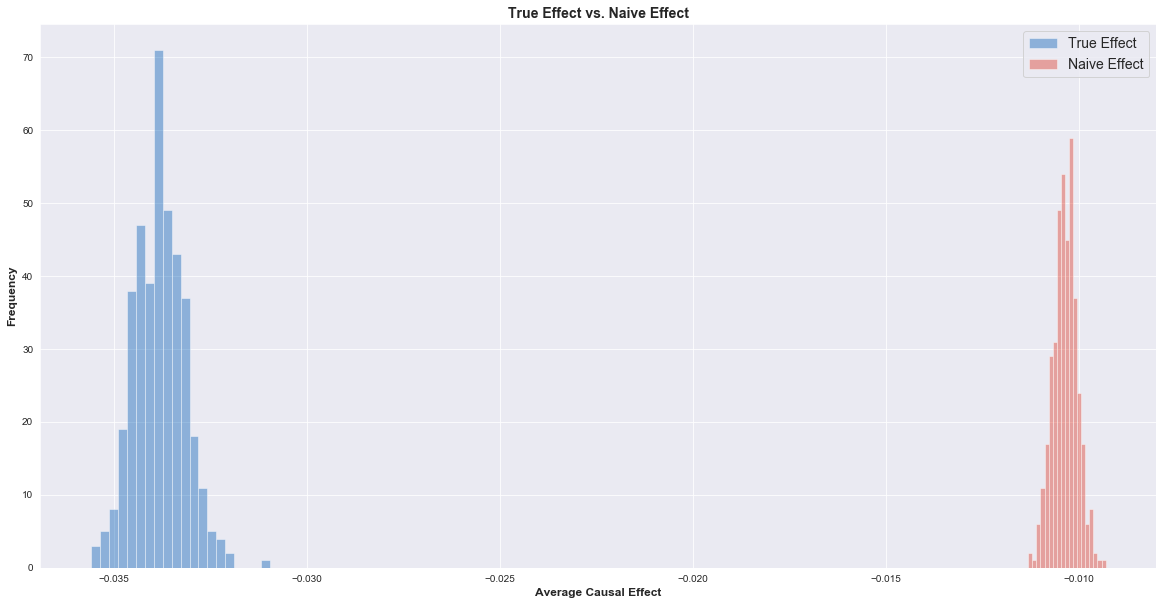

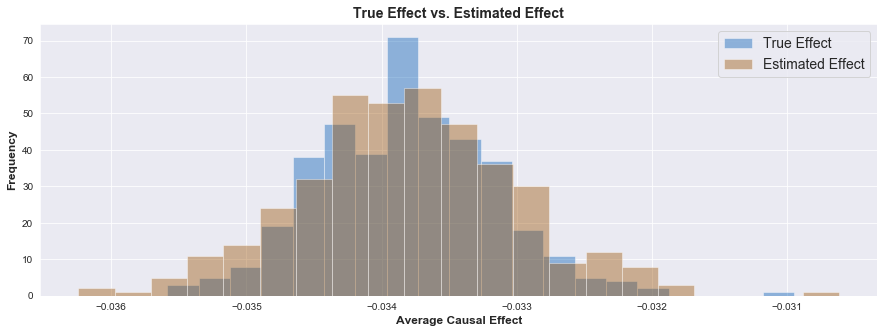

In [86]:
plt.figure(figsize=(20,10))
sns.distplot(causal_effects.true_effect, label='True Effect', kde=False, color='#005AB5')
sns.distplot(causal_effects.naive_effect, label='Naive Effect', kde=False, color='#DC3220')
plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})
plt.ylabel('Frequency', rotation=90, labelpad=5, fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})

plt.figure(figsize=(15,5))
sns.distplot(causal_effects.true_effect, label='True Effect',kde=False, color='#005AB5')
sns.distplot(causal_effects.estimated_effect, label='Estimated Effect', kde=False,color='#994F00')
plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})
plt.ylabel('Frequency', rotation=90, labelpad=5, fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
plt.legend(prop={'size': 14})

Assert that the absolute value of the difference between the naive and true causal effects is greater than the absolute value of the difference between estimated and true causal effects. This we can specify in the future what we think a significant difference between the sides of the inequality should be.

In [237]:
assert abs(np.mean(naive_effect) - np.mean(true_effect)) > abs(np.mean(estimated_effect) - np.mean(true_effect))

In [266]:
import unittest

class TestSuite(unittest.TestCase):
    
    PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'
    data_long = pd.read_csv(PATH)

    def test_DistNodeNoParent(self):
        # Setup
        alternative_id_col = "mode_id"
        observation_id_col = "observation_id"
        alternative_specific_dic = {1:['total_travel_distance'],
                                    2:['total_travel_distance'],
                                    3:['total_travel_distance'],
                                    4:['total_travel_time'],
                                    5:['total_travel_time'],
                                    6:['total_travel_time'],
                                    7:['total_travel_distance'],
                                    8:['total_travel_distance']}

        alternative_name_dic = {1: 'drive_alone',
                                2: 'shared_2',
                                3: 'shared_3p',
                                4: 'wtw',
                                5: 'dtw',
                                6: 'wtd',
                                7: 'walk',
                                8: 'bike'}

        individual_specific_variables = ["household_size", "num_kids",
                                         "num_cars", "num_licensed_drivers"]
        trip_specific_variables = ["cross_bay"]
        variable_type = {'num_kids': 'categorical',
                         'household_size': 'categorical',
                         'num_cars': 'categorical',
                         'num_licensed_drivers': 'categorical',
                         'cross_bay': 'categorical',
                         'total_travel_time': 'continuous',
                         'total_travel_distance': 'continuous',
                         'total_travel_cost': 'continuous'}

        distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']


        # Exercise
        params_dic = DistNodeNoParent(data_long=self.data_long, 
                                       alt_id_col=alternative_id_col,
                                       obs_id_col=observation_id_col,
                                       alt_spec_dic=alternative_specific_dic,
                                       alt_name_dic=alternative_name_dic,
                                       ind_spec=individual_specific_variables,
                                       trip_spec=trip_specific_variables,
                                       var_types=variable_type,
                                       cont_dists=distributions)

        # Verify
        truth_params_dic = {'household_size': {'distribution': 'categorical',
                            'parameters': [np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
                               np.array([0., 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
                                      0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
                             'num_kids': {'distribution': 'categorical',
                              'parameters': [np.array([0, 1, 2, 3, 4, 5, 6]),
                               np.array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
                                      0.00699301, 0.0014985 ])]},
                             'num_cars': {'distribution': 'categorical',
                              'parameters': [np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
                               np.array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
                                      0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
                             'num_licensed_drivers': {'distribution': 'categorical',
                              'parameters': [np.array([0., 1., 2., 3., 4., 5., 6.]),
                               np.array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
                                      4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
                             'total_travel_distance_drive_alone': {'distribution': 'gamma',
                              'parameters': (0.7944517942940816, 0.39999999999999997, 19.10566310726253)},
                             'total_travel_distance_shared_2': {'distribution': 'gamma',
                              'parameters': (0.8148950757692075, 0.29999999999999993, 18.40250347572789)},
                             'total_travel_distance_shared_3p': {'distribution': 'gamma',
                              'parameters': (0.8135746709638757, 0.29999999999999993, 18.437320030510342)},
                             'total_travel_time_wtw': {'distribution': 'alpha',
                              'parameters': (3.9577465114167927, -98.3112671568787, 749.7787691208105)},
                             'total_travel_time_dtw': {'distribution': 'gamma',
                              'parameters': (2.6059274863539046, 8.099701135792749, 30.976197249989433)},
                             'total_travel_time_wtd': {'distribution': 'gamma',
                              'parameters': (2.547895345348514, 7.666262097694567, 30.99344922438852)},
                             'total_travel_distance_walk': {'distribution': 'alpha',
                              'parameters': (1.985330145127784e-06,
                               -1.6062753376988779,
                               5.430955769911186)},
                             'total_travel_distance_bike': {'distribution': 'alpha',
                              'parameters': (0.0023562351887384068,
                               -1.4282411165328406,
                               4.999096383807641)},
                             'cross_bay': {'distribution': 'categorical',
                              'parameters': [np.array([0, 1]), np.array([0.94005994, 0.05994006])]}}

        for k in truth_params_dic.keys():
            np.testing.assert_string_equal(truth_params_dic[k]['distribution'], params_dic[k]['distribution'])
            np.testing.assert_array_almost_equal(truth_params_dic[k]['parameters'], params_dic[k]['parameters'])
            
    def test_SimNodeNoParent(self):
        # Setup
        params_dict = {'x':{'distribution': 'categorical',
                            'parameters': [np.array([0, 1, 2]),
                                           np.array([0.5, 0.25, 0.25])]},
                       'y':{'distribution': 'constant',
                            'parameters': 5 },
                       'z':{'distribution': 'norm',
                            'parameters': (20, 1.2)}
                      }
        
        # Exercise
        actual_data = SimNodeNoParent(params_dict, size=100000)
        
        # Verify
        x = np.random.choice(a=[0, 1, 2], p=[0.5, 0.25, 0.25], size=100000)
        y = [5]*100000
        z = scipy.stats.norm.rvs(loc=20,scale=1.2, size=100000)
        expected_data = pd.DataFrame(data={'x': x, 'y': y, 'z': z})
        np.testing.assert_array_less(abs(expected_data['x'].mean() - actual_data['x'].mean()), 0.01)
        np.testing.assert_array_equal(expected_data['y'].unique(), actual_data['y'].unique())
        np.testing.assert_array_less(abs(expected_data['z'].mean() - actual_data['z'].mean()), 0.1) # the 0.1 can be discussed
        np.testing.assert_array_less(abs(expected_data['z'].std() - actual_data['z'].std()), 0.1) # the 0.1 can be discussed
        
    def test_SimulateAvailability(self):
        # Setup
        alternative_id_col = "mode_id"
        observation_id_col = "observation_id"
        alternative_name_dic = {1: 'drive_alone',
                                2: 'shared_2',
                                3: 'shared_3p',
                                4: 'wtw',
                                5: 'dtw',
                                6: 'wtd',
                                7: 'walk',
                                8: 'bike'}
        sim_size = len(bike_data_long[observation_id_col].unique())
        
        # Exercise -- This might need to change
        # Mainly because of the restriction on the simulation size
        # Currently, sim_size is the same length as the
        # long format dataset
        actual_av_matrix = SimulateAvailability(data_long=self.data_long, sim_size=sim_size, obs_id_col=observation_id_col, alt_name_dict=alternative_name_dic)
        
        # Verify
        actual_sum = actual_av_matrix.values.sum()
        expected_sum = self.data_long.groupby(observation_id_col).count()[alternative_id_col].sum()
        ratio = expected_sum/actual_sum
        difference = abs(ratio-1)
        np.testing.assert_array_less(difference, 0.05) # 0.05 can be discussed

In [267]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/fitter/fitter.py:411: PendingDeprecationWarning: isAlive() is deprecated, use is_alive() instead
  if it.isAlive():
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
...
----------------------------------------------------------------------
Ran 3 tests in 22.240s

OK
